# Machine Learning: Personal Loan Campaign 

## Problem Statement


**Context**

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

**Objective**

- Predict whether a liability customer will accept a personal loan offer.
- Identify key factors influencing customer decisions.
- Optimize marketing strategies by targeting the right customer segments.

**Data Dictionary**

1. ID: Customer ID
2. Age: Customer’s age in completed years
3. Experience: #years of professional experience
4. Income: Annual income of the customer (in thousand dollars)
5. ZIP Code: Home Address ZIP code.
6. Family: the Family size of the customer
7. CCAvg: Average spending on credit cards per month (in thousand dollars)
8. Education: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
9. Mortgage: Value of house mortgage if any. (in thousand dollars)
10. Securities_Account: Does the customer have securities account with the bank?
11. CD_Account: Does the customer have a certificate of deposit (CD) account with the bank?
12. Online: Do customers use internet banking facilities?
13. CreditCard: Does the customer use a credit card issued by any other Bank (excluding All life Bank)?
14. Personal_Loan: Did this customer accept the personal loan offered in the last campaign?

**Domain Information**

mortgage - it represents the amount the customer owes on a loan they took to purchase a house.

**Key Questions that can be answered**

1. What customer attributes contribute the most to loan acceptance?
2. Which customer segments should the bank focus on for better conversion?
3. Are there any patterns or trends in customer behavior that influence loan acceptance?
4. How can the bank use these insights to improve future marketing campaigns?

## Data background and Contents


The dataset contains 14 columns, including:

- **Customer demographics**: Age, Experience, Education, Family, ZIP Code
- **Financial attributes**: Income, CCAvg, Mortgage
- **Banking behavior**: Securities_Account, CD_Account, Online, CreditCard
- **Target variable**: Personal_Loan (0 = No, 1 = Yes)

#### Preparation

In [1]:
# verify
import sys
print(sys.executable, sys.version)

/Users/nipunshah/anaconda3/bin/python 3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]


In [2]:
# Use this cell to install the libraries if absent (for entire project)
# command to install missingno (uncomment below if not installed)
# !conda install -y missingno

In [143]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For missing value visualization
import tabulate as tb

# ML - model building
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, ConfusionMatrixDisplay, make_scorer
# helful for plots of decision boundary
from sklearn import tree

# Suppress warnings
import warnings
warnings.filterwarnings('ignore') # Ignores all warnings (optional)


In [4]:
# Global options and themes

# Set pandas display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)      # Show 100 rows by default

# Seaborn theme for consistent plotting style
sns.set_theme(style="whitegrid", palette="muted", context="notebook")  # You can change it to darkgrid, ticks, etc.
#plt.rcParams["figure.figsize"] = (12, 8)  # Set default figure size for plots
#plt.rcParams["figure.figsize"] = (10, 6)  # Set default figure size for plots
plt.rcParams["figure.figsize"] = (15, 5)  # Set default figure size for plots
plt.rcParams["font.size"] = 14            # Set font size for readability

# restrict float display to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format


In [5]:
# Helpers

# Display horizontally using tabulate
def tb_describe(df_col):
    """
    Helper function to display descriptive statistics in a nicely formatted table

    Parameters:
    df_col : pandas Series or DataFrame column
        The column to generate descriptive statistics for

    Returns:
    None - prints formatted table
    """
    stats = df_col.describe().to_frame().T
    print(tb.tabulate(stats, headers='keys', tablefmt='simple', floatfmt='.2f'))

In [6]:
# Primitive Utils
def snake_to_pascal(snake_str, join_with=" "):
    """Convert snake_case to PascalCase (eg my_name -> MyName)
    Args:
        snake_str (str): string to convert
        join_with (str): character to join the components, default is space
    """
    components = snake_str.split("_")
    return join_with.join(x.title() for x in components)


def format_pct(val):
    """Format a val as percentage i.e max 2 decimal value & adding % at the end"""
    return f"{val:.1f}%"

def to_percentage(value):
    """value is expected to be a normalized float value in [0, 1]"""
    return format_pct(value * 100)

In [7]:
def draw_countplot(
    df,
    colName: str,
    *,
    label=None,
    rot=0,
    order=None,
    sort=True,
    palette=None,
    showgrid=None,
):
    """
    Draw a count plot with value labels and optional features

    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing the data
    colName : str
        Column name to plot
    label : str, optional
        Custom x-label (defaults to formatted column name)
    rot : int, optional
        Rotation angle for x-axis labels
    order : list, optional
        Custom order for categories
    sort : bool, optional
        Whether to sort by count (only used if order is None)
    palette : str or list, optional
        Color palette for bars
    showgrid : bool, optional
        Whether to show grid lines
    """
    # prep (meta) --
    xlabel = label if label else snake_to_pascal(colName)
    priority = None
    if order is not None:
        priority = order
    elif sort:
        # sort by count
        priority = df[colName].value_counts().index

    # plot (crux) --
    ax = sns.countplot(data=df, x=colName, order=priority, palette=palette)
    # display count above each bar
    ax.bar_label(ax.containers[0])

    # Calculate & mark percentages
    total = len(df[colName])
    for p in ax.patches:
        freq = p.get_height()
        percentage = to_percentage(freq / total)
        ax.annotate(
            percentage,
            (p.get_x() + p.get_width() / 2.0, freq / 2.0),
            ha="center",
            va="center",
        )

    # aesthetics --
    plt.title(f"Frequency of {xlabel}")
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.xticks(rotation=rot)
    if showgrid:
        plt.grid(True)
    plt.show()

#### Load the Data

In [8]:
# list all files in current directory
!ls

Loan_Modelling.csv    notebook1.ipynb       notebook1backup.ipynb


In [9]:
# Load the dataset
df = pd.read_csv('Loan_Modelling.csv')
# backup of original df
df_original = df.copy()

#### Understand the Dataset

In [10]:
# Peek the dataset
df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.00,2,0,0,0,0,0,1


In [9]:
# Shape (Size)
df.shape

(5000, 14)

There are total 5000 customers in dataset and 14 attributes per each customer

In [10]:
# Data Types
df.dtypes

ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIPCode                 int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal_Loan           int64
Securities_Account      int64
CD_Account              int64
Online                  int64
CreditCard              int64
dtype: object

All the columns holds values in numerical format

In [13]:
# Unique values in each column
df.nunique()

ID                    5000
Age                     45
Experience              47
Income                 162
ZIPCode                467
Family                   4
CCAvg                  108
Education                3
Mortgage               347
Personal_Loan            2
Securities_Account       2
CD_Account               2
Online                   2
CreditCard               2
dtype: int64

The following columns can be treated as categorical variables:
CreditCard, Online, CD_Account, Securities_Account, Personal_Loan, Education, Family 
as they possess few unique values

Additionally, ID and ZIPCode columns can be excluded from analysis since they contain
too many unique values and don't provide meaningful patterns.

In [14]:
# Columns Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [40]:
# Missing values
missing_values = df.isnull().sum().sum()
missing_values

0

There are no missing values in dataset

In [16]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


No duplicates as well :- All the rows are uniques (ie No repeat of customer in records)

In [113]:
# Statistical summary
stats = df.describe(include='all').T
stats

,count,mean,std,min,25%,50%,75%,max
ID,5000.00,2500.50,1443.52,1.00,1250.75,2500.50,3750.25,5000.00
Age,5000.00,45.34,11.46,23.00,35.00,45.00,55.00,67.00
Experience,5000.00,20.10,11.47,-3.00,10.00,20.00,30.00,43.00
Income,5000.00,73.77,46.03,8.00,39.00,64.00,98.00,224.00
ZIPCode,5000.00,93169.26,1759.46,90005.00,91911.00,93437.00,94608.00,96651.00
Family,5000.00,2.40,1.15,1.00,1.00,2.00,3.00,4.00
CCAvg,5000.00,1.94,1.75,0.00,0.70,1.50,2.50,10.00
Education,5000.00,1.88,0.84,1.00,1.00,2.00,3.00,3.00
Mortgage,5000.00,56.50,101.71,0.00,0.00,0.00,101.00,635.00
Personal_Loan,5000.00,0.10,0.29,0.00,0.00,0.00,0.00,1.00


Observations 🔍

Total customers :- 5000 carrying 14 characteristics related to bank

**Numerical Variables**:
- Age ranges from 23-67 years, with average of 45 years
- Experience ranges from -3 to 43 years, with average being 20 years  
- Income ranges from $8K-$224K, with mean of $74K
- Average credit card spending ranges from $0-$10K monthly
- Mortgage ranges from $0-$635K, with mean of $57K

**Categorical/Binary Variables**:
- Only 10% of customers have taken Personal Loan (target variable)
- 10% have Securities Account
- 6% have CD Account
- 60% use Online banking
- 29% have Credit Card

**Other Notes**:
- Education levels are 1, 2 or 3
- Family size ranges from 1-4 members
- ZIP codes range from 90005-96651

⚡ Note : Experience lowest value is -ve, indicating something fussy !

#### Key Insights 

1. Target Variable: Personal_Loan (0 = No, 1 = Yes)
2. Numerical Features: Age, Experience, Income, CCAvg, Mortgage
3. Categorical Features: Education, Family, Securities_Account, CD_Account, Online, CreditCard
4. Potential Issues:
   - ZIP Code is likely irrelevant for prediction.
   - Experience and Age might be highly correlated.

> PLOTS: Since Decision Trees are non-parametric and handle outliers well, we focus less on **normality** and **transformations** but more on **variable importance** and **interactions**

## Univariate Analysis (EDA)

##### 1) Age

In [18]:
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal_Loan', 'Securities_Account',
       'CD_Account', 'Online', 'CreditCard'],
      dtype='object')

In [19]:
uniques = df['Age'].nunique()
uniques

45

Age is discrete numerical value with meaningful ordering which possess low cardinality !!

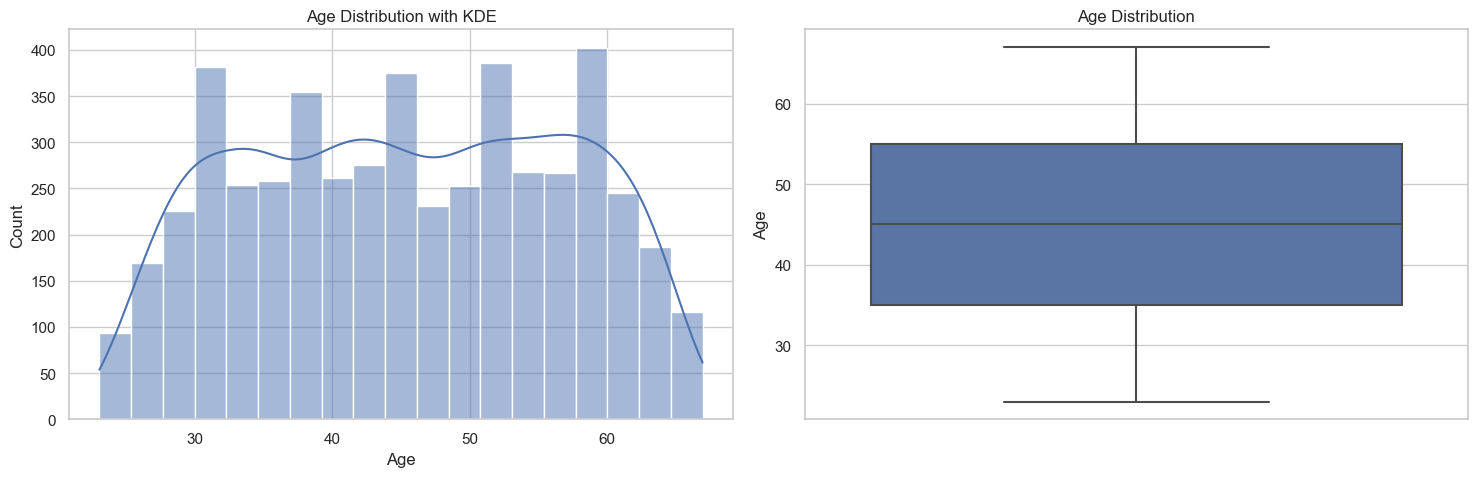

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Histogram with KDE
sns.histplot(data=df, x='Age', kde=True, ax=ax1)
ax1.set_title('Age Distribution with KDE')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')

# Plot 2: Box Plot of Age
sns.boxplot(data=df, y='Age', ax=ax2)
ax2.set_title('Age Distribution')
ax2.set_ylabel('Age')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [21]:
tb_describe(df['Age'])

       count    mean    std    min    25%    50%    75%    max
---  -------  ------  -----  -----  -----  -----  -----  -----
Age  5000.00   45.34  11.46  23.00  35.00  45.00  55.00  67.00


In [22]:
print('Skewness of Age : ', df['Age'].skew())
print('Kurtosis of Age : ', df['Age'].kurt())

Skewness of Age :  -0.02934068151284029
Kurtosis of Age :  -1.1530672623735783


Skewness (-0.0293) → Nearly Symmetric
- Age is evenly distributed and does not need transformation

Kurtosis (-1.153) → Flat Distribution
- No strong peaks, meaning Age is spread out with fewer extreme values.

Decision Tree will consider a wide range of values when splitting.

#### 2) Experience

In [46]:
df['Experience'].nunique()

47

In [48]:
tb_describe(df['Experience'])

              count    mean    std    min    25%    50%    75%    max
----------  -------  ------  -----  -----  -----  -----  -----  -----
Experience  5000.00   20.10  11.47  -3.00  10.00  20.00  30.00  43.00


Negative values: This is unusual! Experience should not logically have negative values. There might be due to data entry errors or something else

In [49]:
# check for negative values
negative_experience = df[df['Experience'] < 0]
print('Number of customers with -ve professional experience : ', negative_experience.shape[0])

Number of customers with -ve professional experience :  52


This is relatiely small (ie 52/5000 = 1%)

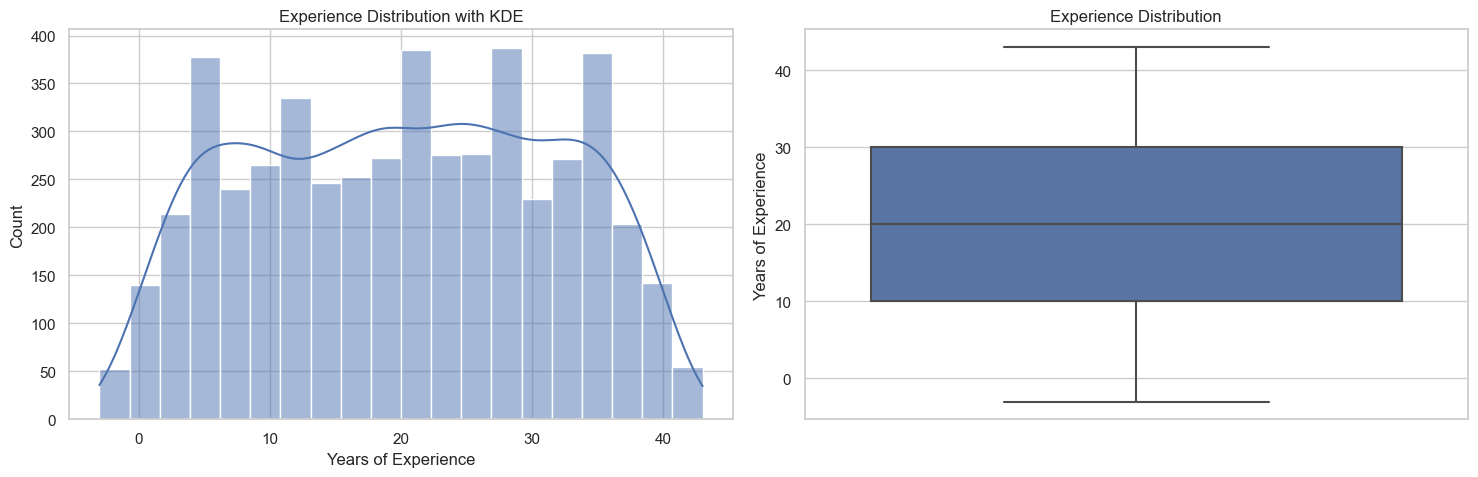

In [50]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Histogram with KDE
sns.histplot(data=df, x='Experience', kde=True, ax=ax1)
ax1.set_title('Experience Distribution with KDE')
ax1.set_xlabel('Years of Experience')
ax1.set_ylabel('Count')

# Plot 2: Box Plot
sns.boxplot(data=df, y='Experience', ax=ax2)
ax2.set_title('Experience Distribution')
ax2.set_ylabel('Years of Experience')

plt.tight_layout()
plt.show()

In [51]:
print('Skewness of Experience : ', df['Experience'].skew())
print('Kurtosis of Experience : ', df['Experience'].kurt())

Skewness of Experience :  -0.026324688402384513
Kurtosis of Experience :  -1.12152278596998


Skewness:
-0.03 (close to 0) suggests that the distribution of Experience is nearly symmetrical. There’s a slight negative skew, but it’s minimal.

Kurtosis:
-1.12 indicates that the distribution is flatter than a normal distribution with fewer and less extreme outliers.

> The symmetrical distribution is good for Decision Trees since the model doesn’t rely on assumptions about the data's distribution.

> Flatness in the distribution suggests that no extreme outliers are present, which is helpful in avoiding unnecessary splits caused by extreme values.

#### 3) Income

In [52]:
tb_describe(df['Income'])

          count    mean    std    min    25%    50%    75%     max
------  -------  ------  -----  -----  -----  -----  -----  ------
Income  5000.00   73.77  46.03   8.00  39.00  64.00  98.00  224.00


In [53]:
print('Skewness of Income : ', df['Income'].skew())
print('Kurtosis of Income : ', df['Income'].kurt())

Skewness of Income :  0.8413386072610816
Kurtosis of Income :  -0.04424418973549038


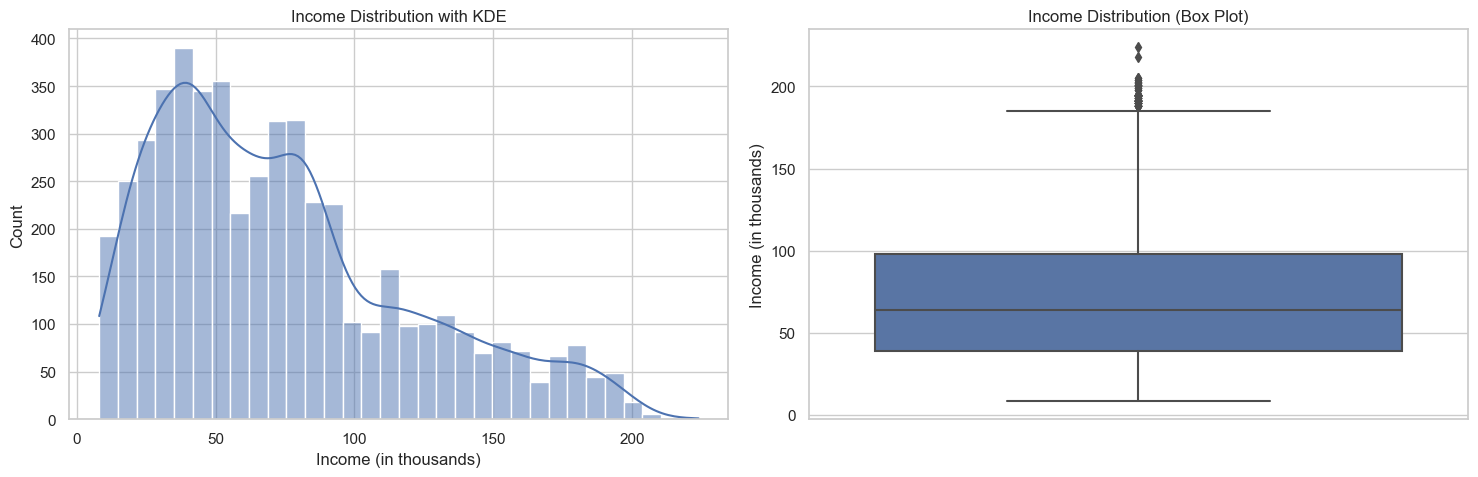

In [62]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot 1: Histogram with KDE
sns.histplot(data=df, x='Income', kde=True, ax=ax1)
ax1.set_title('Income Distribution with KDE')
ax1.set_xlabel('Income (in thousands)')
ax1.set_ylabel('Count')

# Plot 2: Box Plot
sns.boxplot(y=df['Income'], ax=ax2)
ax2.set_title('Income Distribution (Box Plot)')
ax2.set_ylabel('Income (in thousands)')

plt.tight_layout()
plt.show()

Observation 

Looking at our plot:
- First valley: Around $40-45K
- Major peak: Around $70-80K
- Second valley: Around $110-120K
- Upper tail: Beyond $150K

The decision tree might create splits at these valleys because:
- They represent natural breaks in income distribution
- They separate distinct income groups
- They minimize within-group variance

In [79]:
log_income = np.log10(df['Income'] + 1)

print('Skewness of Log-Transformed Income : ', log_income.skew())
print('Kurtosis of Log-Transformed Income : ', log_income.kurt())

Skewness of Log-Transformed Income :  -0.42071189305490686
Kurtosis of Log-Transformed Income :  -0.309721731205979


Now the distribution is relatively more balanced

In [80]:
tb_describe(log_income)

          count    mean    std    min    25%    50%    75%    max
------  -------  ------  -----  -----  -----  -----  -----  -----
Income  5000.00    1.78   0.30   0.95   1.60   1.81   2.00   2.35


In [81]:
# Just for understanding & verification
l = 10**0.95
r = 10**2.35
print(l, r)

8.912509381337454 223.872113856834


This is near to 8 <-> 224 (from original range)

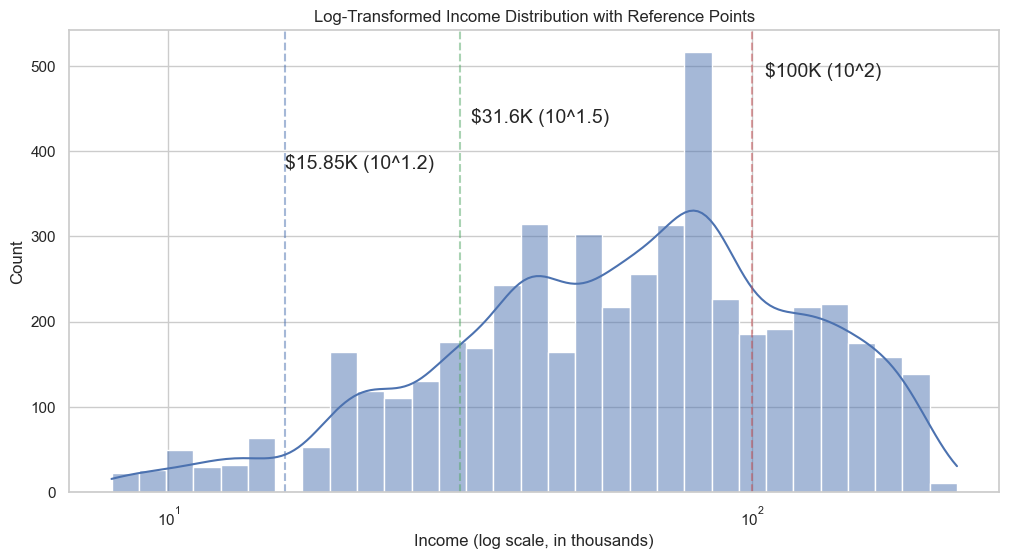

In [75]:
# Create log-transformed plot with reference lines
plt.figure(figsize=(12, 6))

# Main histogram with KDE
sns.histplot(data=df, x='Income', kde=True, log_scale=True)

# Add vertical reference lines with annotations
plt.axvline(x=100, color='r', linestyle='--', alpha=0.5)
plt.text(105, plt.ylim()[1]*0.9, '$100K (10^2)', rotation=0)

plt.axvline(x=31.6, color='g', linestyle='--', alpha=0.5)
plt.text(33, plt.ylim()[1]*0.8, '$31.6K (10^1.5)', rotation=0)

plt.axvline(x=15.85, color='b', linestyle='--', alpha=0.5)
plt.text(15.85, plt.ylim()[1]*0.7, '$15.85K (10^1.2)', rotation=0)

plt.title('Log-Transformed Income Distribution with Reference Points')
plt.xlabel('Income (log scale, in thousands)')
plt.ylabel('Count')

plt.show()

Advantages 

- Stretched out compress areas of original histogram
- Makes valleys and peaks visible across ALL income ranges
- Shows natural groupings that were hidden in original scale

Observation 

1. **There is natural seperation point at ~$16K, Tree might use this as splitting criteria**
2. Natural seperation point between 2 income group (ie <= 100K & > 100K). This valley suggests these groups might have different loan acceptance behaviors


#### 4) ZipCode 

(home address zip code (ie pincode))

In [10]:
# check for unique values
df['ZIPCode'].nunique()

467

ref: https://www.smarty.com/docs/zip-codes-101

The first 3 digits denotes Major Mail Processing Center (SCF) (ie Geography)

> Let's try to explore it

In [13]:
# Create a new column with first 3 digits of ZIP code
area_code = df['ZIPCode'].astype(str).str[:3]

# Count unique regions
n_regions = area_code.nunique()
print(f"Number of unique regions (3-digit ZIP): {n_regions}")

# Get distribution of regions
area_code.describe()

Number of unique regions (3-digit ZIP): 57


count     5000
unique      57
top        900
freq       375
Name: ZIPCode, dtype: object

The zip code starting with 900 is in California. It includes zip codes for cities like Los Angeles and Oakwood

Although reducing zip codes to 57 regions helps with cardinality, including them may not be viable for the Personal Loan Campaign, as the geographic information might not significantly influence loan acceptance, potentially adding unnecessary complexity without substantial predictive value. (this needs domain know-how inclusion)

##### TODO: Add ZipCode (uszipcode) code here from experiment performed in colab

In [ ]:
# TODO: add code from colab in future (for Cities and States Exploration)

#ref:https://colab.research.google.com/drive/1C8-cFBW-v5sMzAFgcJFQAJgTUOh3nH-L#scrollTo=5tTyjW9BCSdl

📌 Points:

Single State: All customers are from single state
- This suggests a localized customer base
- Might be a regional bank or branch focus

244 Cities:
- good geographic spread within state (ie California) ie urban + suburban + rural mix
- 244 is still high cardinality

ZIP code doesn't add significant predictive value

Observations 🔍

1. High Cardinality
- 467 unique values
- too many categories for meaniful splits
- Could lead to overfitting

2. No Direct Influence (domain knowhow)
- ZIP codes are just location identifiers
- Don't directly impact loan acceptance behavior (esp. for an individual)
- Any patterns might be coincidental

#### 5) Family (size)

In [14]:
df['Family'].nunique()

4

As there are 4 distinct values so lets treat it as categorical variable

In [45]:
# make it categorical
family_col = df['Family'].astype('category')
family_col.dtype

CategoricalDtype(categories=[1, 2, 3, 4], ordered=False)

In [61]:
family_col.describe()

count     5000
unique       4
top          1
freq      1472
Name: Family, dtype: int64

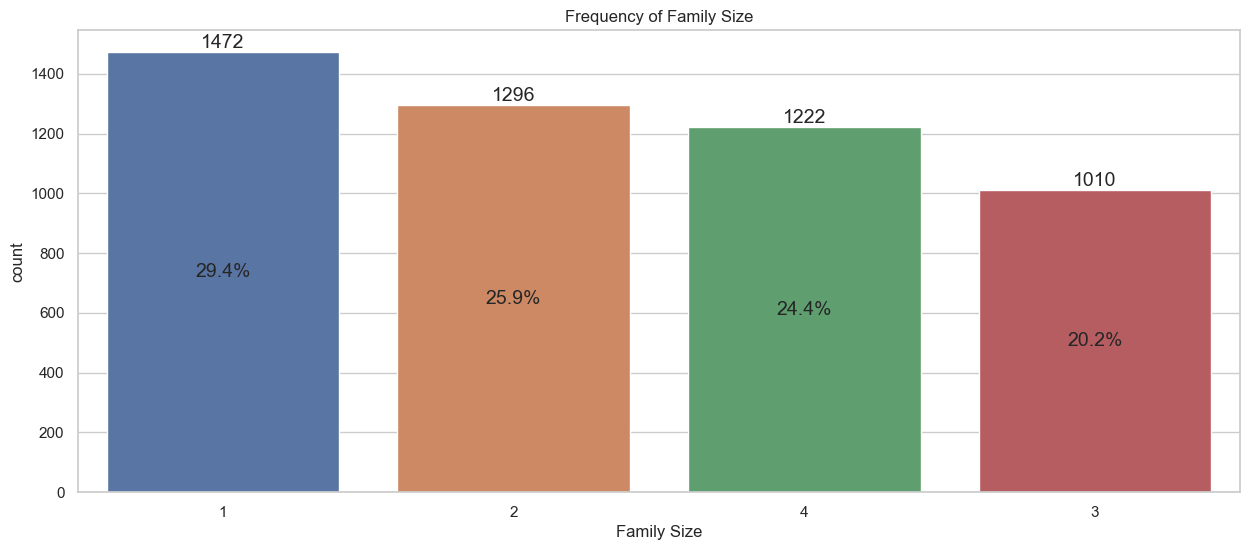

In [59]:
plt.figure(figsize=(15, 6))
draw_countplot(df, 'Family', label='Family Size')

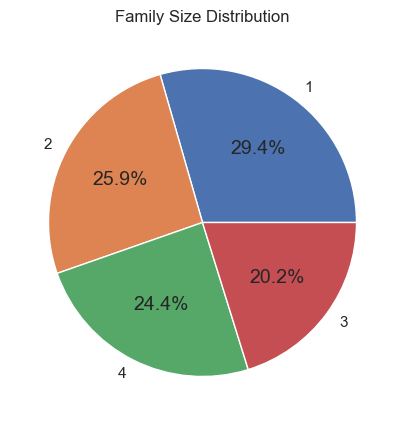

In [63]:
family_counts = df['Family'].value_counts()
family_counts.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.ylabel('')  # Remove y-label
plt.title('Family Size Distribution')
plt.show()

In [60]:
family_counts = df['Family'].value_counts()
family_counts

1    1472
2    1296
4    1222
3    1010
Name: Family, dtype: int64

The family size feature shows a fairly balanced distribution with the majority of customers having family sizes 1, 2, or 4. The smallest group is 3.

- No dominant class
- Could be useful for splitting features as tree won't favor a dominant class

#### 6) CCAvg (Avg credit card spending / month)

In [66]:
tb_describe(df['CCAvg'])

         count    mean    std    min    25%    50%    75%    max
-----  -------  ------  -----  -----  -----  -----  -----  -----
CCAvg  5000.00    1.94   1.75   0.00   0.70   1.50   2.50  10.00


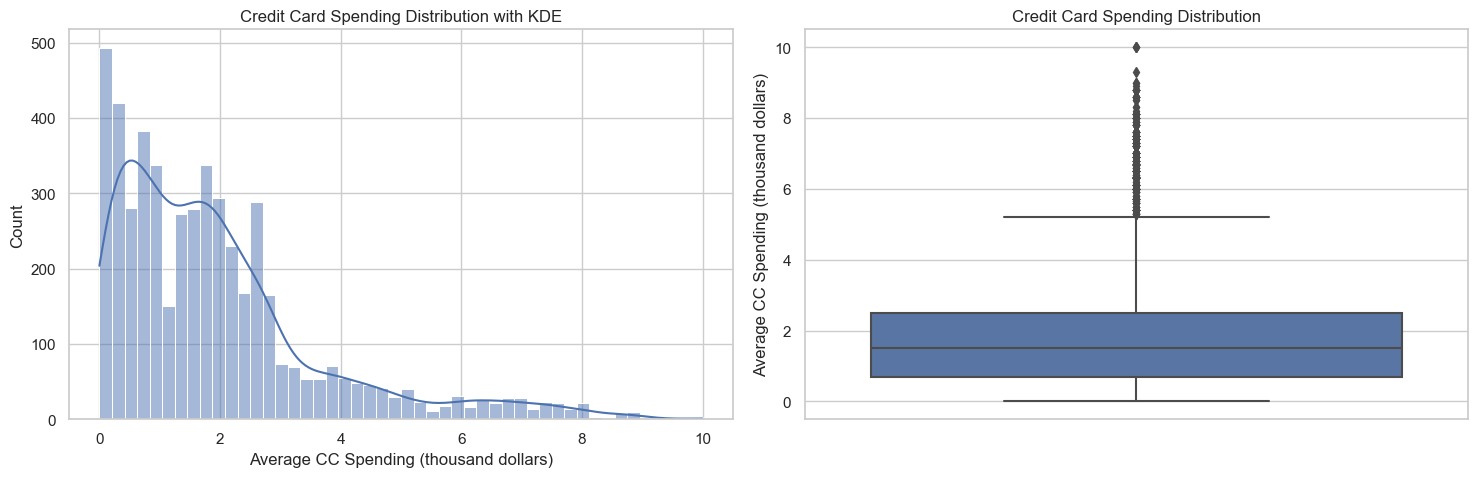

In [68]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Histogram with KDE
sns.histplot(data=df, x='CCAvg', kde=True, ax=ax1)
ax1.set_title('Credit Card Spending Distribution with KDE')
ax1.set_xlabel('Average CC Spending (thousand dollars)')
ax1.set_ylabel('Count')

# Plot 2: Box Plot
sns.boxplot(y=df['CCAvg'], ax=ax2)
ax2.set_title('Credit Card Spending Distribution')
ax2.set_ylabel('Average CC Spending (thousand dollars)')

# Adjust layout and display
plt.tight_layout()
plt.show()

Multiple valleys can be spotted from the plot, hence making them candidate for split by decision classifier

In [69]:
# Print skewness and kurtosis
print("\nSkewness:", df['CCAvg'].skew())
print("Kurtosis:", df['CCAvg'].kurt())


Skewness: 1.5984433366678663
Kurtosis: 2.646706374237909


Observations:
1. The average monthly credit card spending is $1,940
2. 50% of customers spend $1,500 or less per month (median)
3. There's a wide range from $0 to $10,000 monthly spending
4. The 75th percentile is $2,500, meaning most customers spend moderately
5. The distribution is right-skewed

Plot seems to be skewed on right side with heavy tail


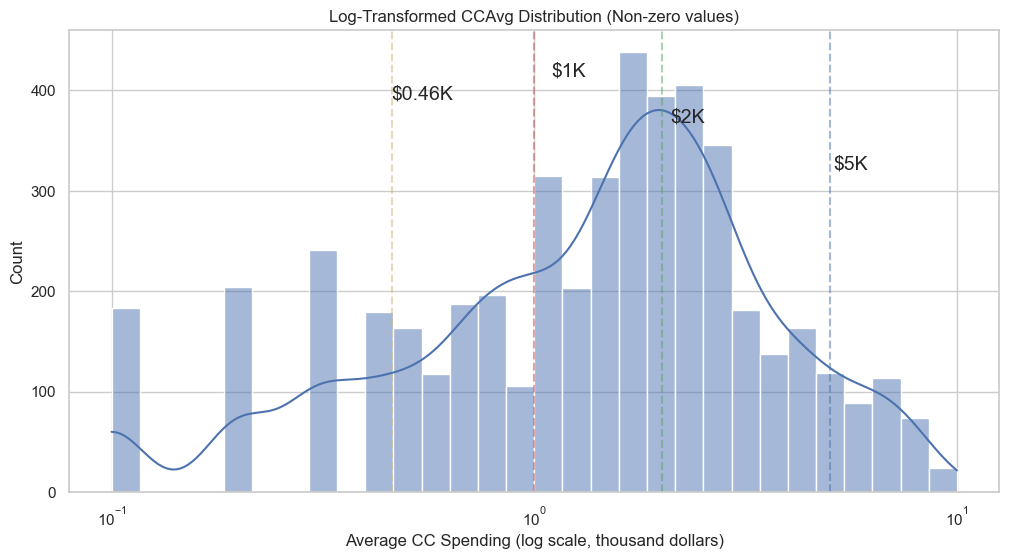

Number of customers with zero CC spending: 106


In [34]:
plt.figure(figsize=(12, 6))

# Filter out zeros and plot with log scale
non_zero_ccavg = df[df['CCAvg'] > 0]['CCAvg']
sns.histplot(data=non_zero_ccavg, kde=True, log_scale=True)

plt.title('Log-Transformed CCAvg Distribution (Non-zero values)')
plt.xlabel('Average CC Spending (log scale, thousand dollars)')
plt.ylabel('Count')

# Add reference lines
plt.axvline(x=0.46, color='y', linestyle='--', alpha=0.5)
plt.text(0.46, plt.ylim()[1]*0.85, '$0.46K', rotation=0)

plt.axvline(x=1, color='r', linestyle='--', alpha=0.5)
plt.text(1.1, plt.ylim()[1]*0.9, '$1K', rotation=0)

plt.axvline(x=2, color='g', linestyle='--', alpha=0.5)
plt.text(2.1, plt.ylim()[1]*0.8, '$2K', rotation=0)

plt.axvline(x=5, color='b', linestyle='--', alpha=0.5)
plt.text(5.1, plt.ylim()[1]*0.7, '$5K', rotation=0)

plt.show()

# Print number of zero values
print(f"Number of customers with zero CC spending: {len(df) - len(non_zero_ccavg)}")

This is much better comparatively to non-log-transformed

- Easier to identify valeys and peaks
- Slight Flatter distribution, thereby helps identify clear split points, comparatively

Good for finding split points

- Better spread of values can be seen here
- It's more of normal for customers spending atleast around 500 dollar 

**Hence classifier may focus on customers, spending atleast around $500 as their credit card expenditure**

In [16]:
transformed_ccavg = np.log10(df['CCAvg'] + 1)

In [75]:
print('Skewness of Log-Transformed CCAvg : ', transformed_ccavg.skew())
print('Kurtosis of Log-Transformed CCAvg : ', transformed_ccavg.kurt())

Skewness of Log-Transformed CCAvg :  0.31922379644464294
Kurtosis of Log-Transformed CCAvg :  -0.46767694208709853


Observation:
- Better view of spending pattern
- Better spread of values
- $460, $2K, $5K, $1K, seems to be natural breaks as they have peaks and valleys correspondingly
- Most customer have moderate CC spending
- Few customers with very high spending

Classifier might focus on customer spending more than $500, roughly (ie > $460)

NOTE: There are few gaps as well for much lesser spending side which can be picked by tree for splitting criteria as it clearly shows 3 clear gaps

Hence this can be one of the important feature, decision tree might consider for splitting

#### 7) Education
(categorical - ordinal)

In [76]:
df['Education'].nunique()

3

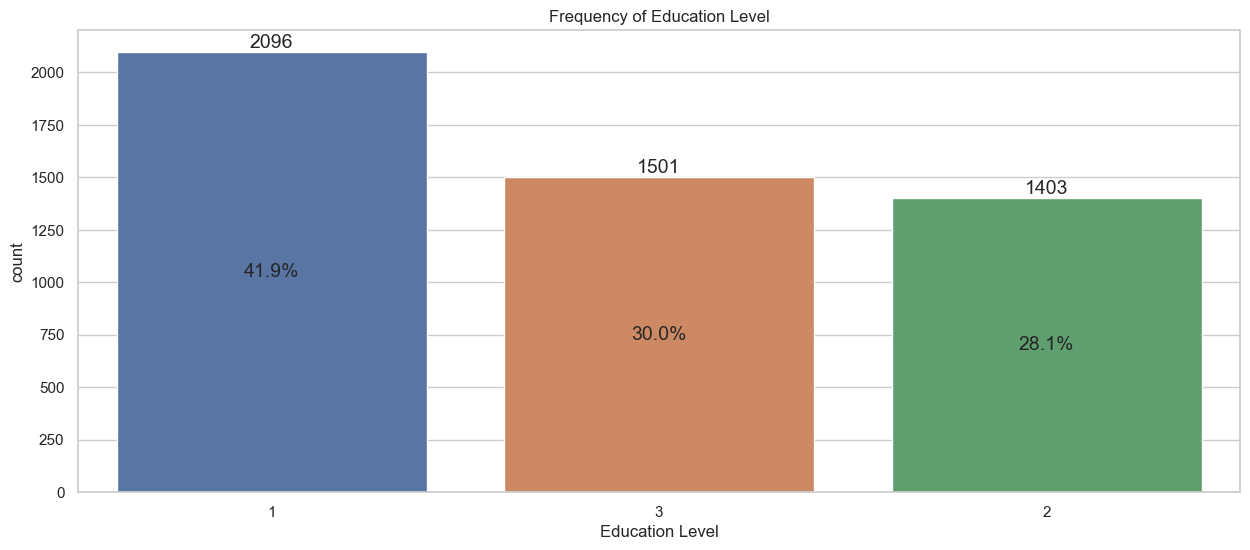

In [80]:
plt.figure(figsize=(15, 6))
draw_countplot(df, 'Education', label='Education Level')

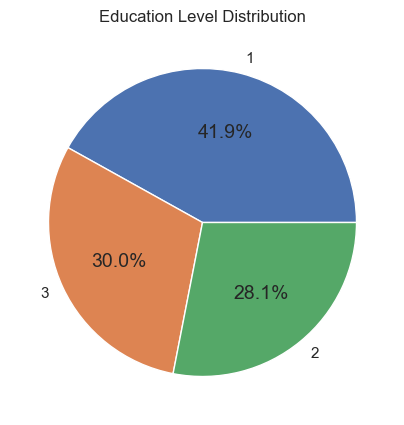

In [81]:
education_counts = df['Education'].value_counts()
education_counts.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.ylabel('')  # Remove y-label
plt.title('Education Level Distribution')
plt.show()

In [82]:
education_counts

1    2096
3    1501
2    1403
Name: Education, dtype: int64

Observations 🔍 

- Most customers (~42%) have undergraduate degree (Education level 1)
- 30% have professional degree (Education level 3)
- 28% have advanced/graduate degree (Education level 2)
- Education level distribution is relatively balanced with slight skew towards undergraduates
- Well-distributed categories with no extreme imbalance, making it a potentially good feature for splitting
- If Education is a key predictor, the tree might favor splitting on Undergraduate vs others first.
- Good mix of education levels in customer base, suggesting need for diverse loan strategies


#### 8) Mortgage
(house loan in dollar, unit - thousand)

In [83]:
tb_describe(df['Mortgage'])

            count    mean     std    min    25%    50%     75%     max
--------  -------  ------  ------  -----  -----  -----  ------  ------
Mortgage  5000.00   56.50  101.71   0.00   0.00   0.00  101.00  635.00


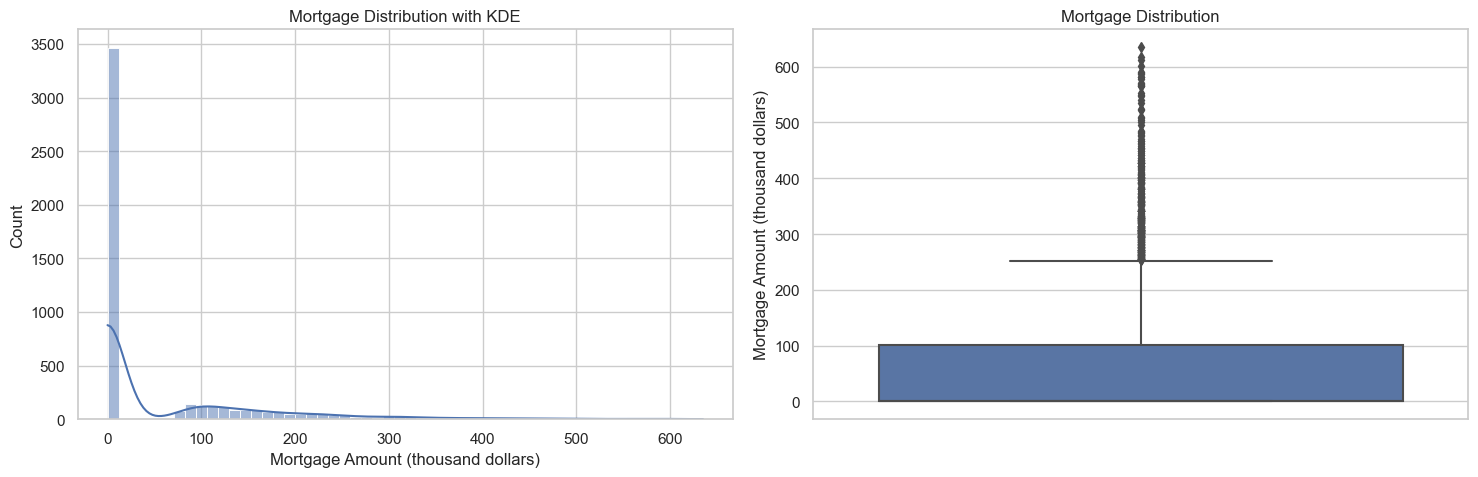

In [86]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Histogram with KDE
sns.histplot(data=df, x='Mortgage', kde=True, ax=ax1)
ax1.set_title('Mortgage Distribution with KDE')
ax1.set_xlabel('Mortgage Amount (thousand dollars)')
ax1.set_ylabel('Count')

# Plot 2: Box Plot
sns.boxplot(y=df['Mortgage'], ax=ax2)
ax2.set_title('Mortgage Distribution')
ax2.set_ylabel('Mortgage Amount (thousand dollars)')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [12]:
# skew and kurtosis
print('Skewness of Mortgage : ', df['Mortgage'].skew())
print('Kurtosis of Mortgage : ', df['Mortgage'].kurt())


Skewness of Mortgage :  2.1040023191079444
Kurtosis of Mortgage :  4.756796669311615


📌 Points

- Seems this is heavily skewed with outliers (ie Rightly Skewed)
- Many Customers with no mortagage value

- **There is a huge gap and a valley as well at same spot between high and low peak of graph, indicating a natural separation in the data distribution**
- This suggests a potential decision boundary for the Decision Tree, as splitting near this region may effectively distinguish different groups. (ie Possess Loan / Didnt Possess Loan)
- The gap also implies that values in this range are rare, which might affect model generalization

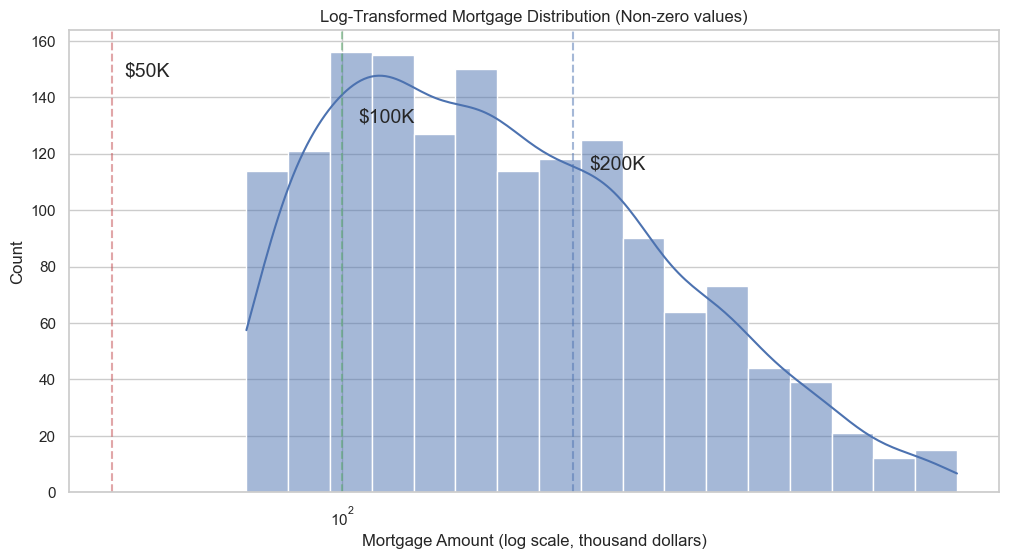

Number of customers with no mortgage: 3462


In [11]:
# log-transformed plot
plt.figure(figsize=(12, 6))

# Filter out zeros and plot with log scale
non_zero_mortgage = df[df['Mortgage'] > 0]['Mortgage']
sns.histplot(data=non_zero_mortgage, kde=True, log_scale=True)

plt.title('Log-Transformed Mortgage Distribution (Non-zero values)')
plt.xlabel('Mortgage Amount (log scale, thousand dollars)')
plt.ylabel('Count')

# Add reference lines
plt.axvline(x=50, color='r', linestyle='--', alpha=0.5)
plt.text(52, plt.ylim()[1]*0.9, '$50K', rotation=0)

plt.axvline(x=100, color='g', linestyle='--', alpha=0.5)
plt.text(105, plt.ylim()[1]*0.8, '$100K', rotation=0)

plt.axvline(x=200, color='b', linestyle='--', alpha=0.5)
plt.text(210, plt.ylim()[1]*0.7, '$200K', rotation=0)

plt.show()

# Print number of zero values
print(f"Number of customers with no mortgage: {len(df) - len(non_zero_mortgage)}")

- Flatter than normal distribution
- Still slightly right skewed, Seems actually there are very less people on heavy loan
- More uniform spread of value for customers who possess loans, comparatively


In [12]:
transformed_mortgage = np.log10(df['Mortgage'] + 1)

In [15]:
# Analyze
skew = transformed_mortgage.skew()
kurt = transformed_mortgage.kurt()

print('Skewness of Log-Transformed Mortgage:', skew)
print('Kurtosis of Log-Transformed Mortgage:', kurt)

Skewness of Log-Transformed Mortgage: 0.8766882783607725
Kurtosis of Log-Transformed Mortgage: -1.1680156143543925


📌 Points

Log Transform plot almost discard people with no mortgage

- Mortgages split into two main groups after log transformation
- Most loans are either around $100K or $200K 
- The two groups likely represent:
  - New homebuyers getting $100K loans
  - Existing owners getting $200K loans

**Zero values consideration**: Since many mortgages are zero, a log transformation might not impact them directly, so an additional categorical flag (e.g., "Has Mortgage" vs. "No Mortgage") could be useful.

- The first peak at 100K might represent a concentration of loans around this value (possibly the most common loan amount or a frequent range).

- The second peak at 200K could suggest another cluster of loans, indicating that borrowers tend to group around these two values.

Decision trees might better capture patterns among customers with mortgages

- This means the decision tree may focus more on customers who actually have a mortgage and might not give much weight to customers who don’t, as the log transformation flattens the distribution for non-loan holders.

Observation 🔍  

- More than Half of our customers don't have any home loans at all
- For those who do have mortgages, the typical amount is around $56,500
- There's a huge variety in mortgage amounts - some have small loans while others have very large ones
- The biggest home loan in our dataset is $635,000
- Looking at the spread: 75% of customers either have no mortgage or owe less than $101,000

#### 9) Securities Account 
(Opted or not) | Binary

In [38]:
df['Securities_Account'].value_counts()

0    4478
1     522
Name: Securities_Account, dtype: int64

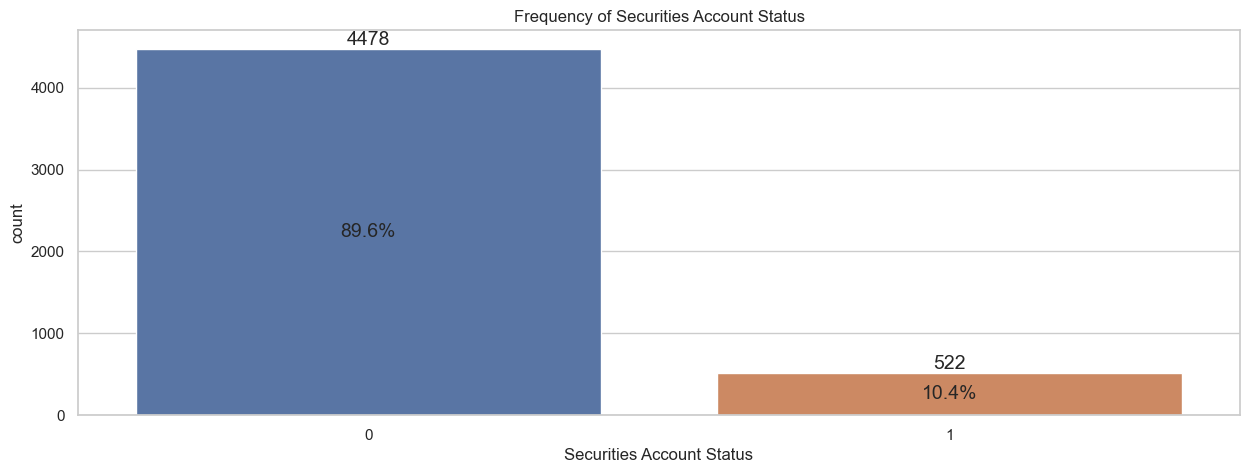

In [39]:
draw_countplot(df, 'Securities_Account', label='Securities Account Status')

📌 Points

Highly imbalanced (≈9:1 ratio)

- Only 10.4% (522) of customers have a securities account
- The vast majority 89.6% (4478) of customers do not have a securities account
- This shows a significant imbalance in securities account holders vs non-holders
- The low percentage of securities account holders suggests this may be a premium/advanced banking service
- Could indicate correlation with higher income/wealth customers. (but Decision Tree doesnt much care about correlation)

> Could be a strong discriminator if correlated with loan acceptance

Since Decision Trees can easily handle categorical data, this imbalance may cause the tree to heavily favor the 0 category. This could potentially reduce the model's performance for the minority class (1) unless handled appropriately.

Poor Recall for Minority Class

The recall for class 1 (Has Security Account) could be low, meaning the model may fail to identify many of the instances where people actually have a security account.




#### 10) CD Account (Certificate of Deposit)
(Opted or not) | Binary

In [41]:
df['CD_Account'].value_counts()

0    4698
1     302
Name: CD_Account, dtype: int64

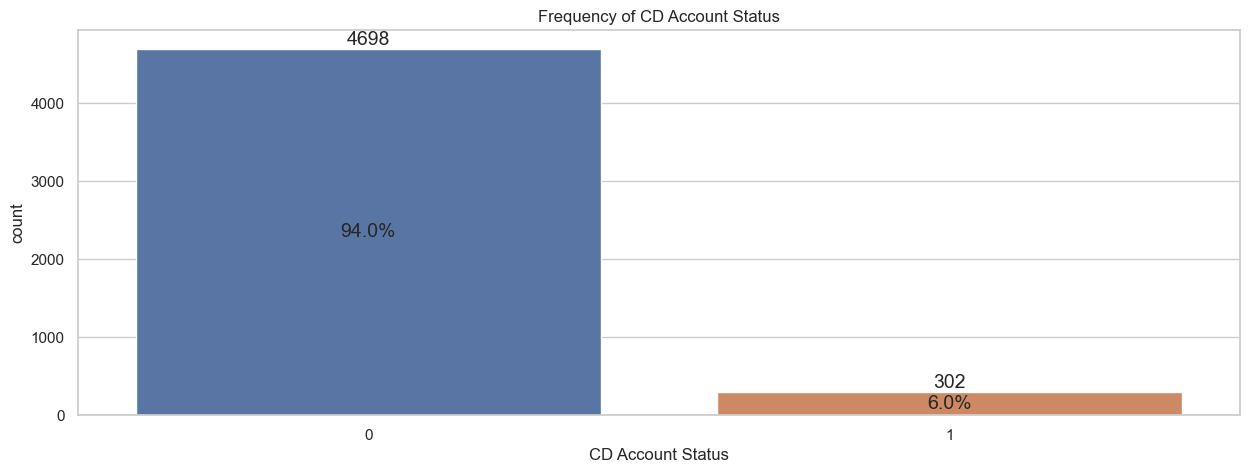

In [42]:
draw_countplot(df, 'CD_Account', label='CD Account Status')

Observations 🔍
- Only 6% (302) of customers have a CD account
- The vast majority 94% (4698) of customers do not have a CD account
- This shows a significant imbalance in CD account holders vs non-holders
- CD accounts appear to be a less common banking product among customers
- The low percentage suggests this may be a specialized banking service

Decision Tree algorithm might overly favor the 0 category (ie No CD account).

#### 11) Online (Banking)
(Use or not) | Binary

In [44]:
df['Online'].value_counts()

1    2984
0    2016
Name: Online, dtype: int64

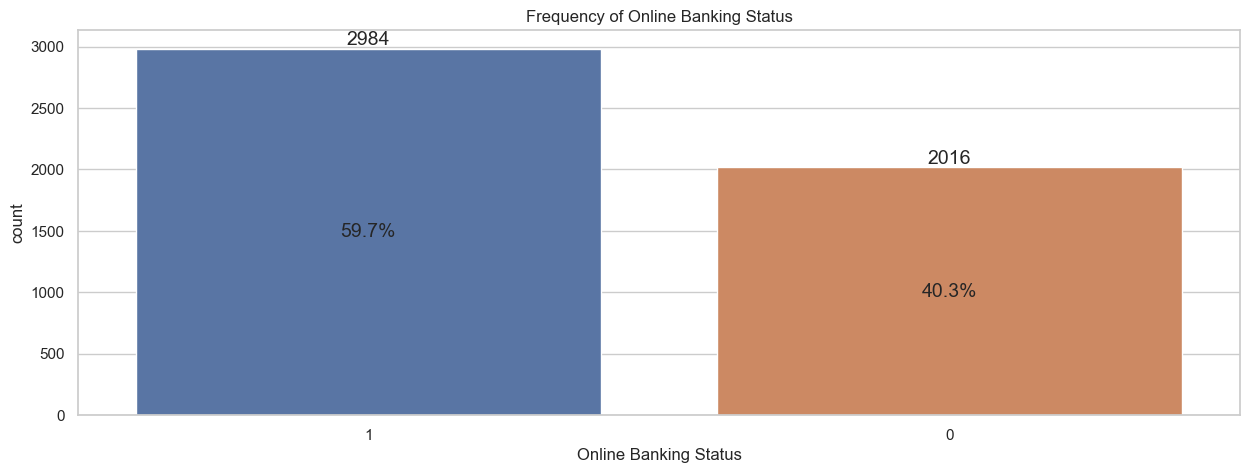

In [45]:
draw_countplot(df, 'Online', label='Online Banking Status')

Observations 🔍
- 59.7% (2984) of customers use online banking services
- 40.3% (2016) of customers do not use online banking
- Online banking adoption is relatively high, with a majority of customers using it
- The distribution is more balanced compared to other binary variables
- This suggests online banking is a mainstream service among the customer base

Fairly balanced
- Decision Tree is less likely to become biased toward one class.
- The relatively balanced distribution in Online Bank Usage makes it easier for the Decision Tree to create meaningful splits without heavy bias toward one class.
- **Accuracy** becomes a more reliable metric.

#### 12) Credit Card (by other bank)

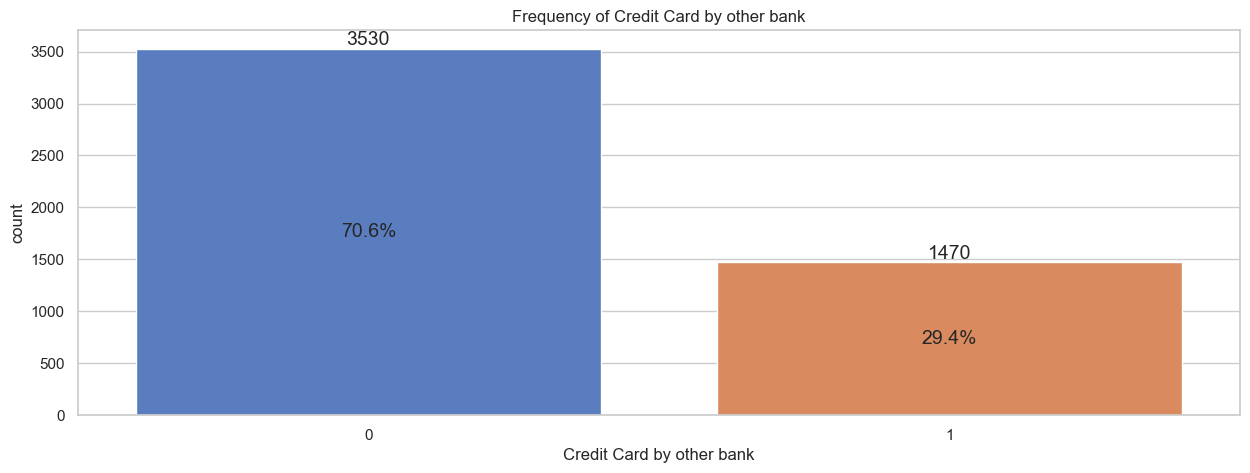

In [61]:
draw_countplot(df, 'CreditCard', label='Credit Card by other bank')

In [62]:
df['CreditCard'].value_counts()


0    3530
1    1470
Name: CreditCard, dtype: int64

Observations 🔍
- 70.6% (3530) of customers do not have credit cards from other banks
- 29.4% (1470) of customers have credit cards from other banks
- This shows a clear majority of customers without external credit cards
- The distribution is moderately imbalanced but not as extreme as some other variables
- This suggests room for potential credit card customer acquisition


#### 13) Personal Loan  (TARGET)
(Opted or not) | Binary

In [36]:
df['Personal_Loan'].value_counts()

0    4520
1     480
Name: Personal_Loan, dtype: int64

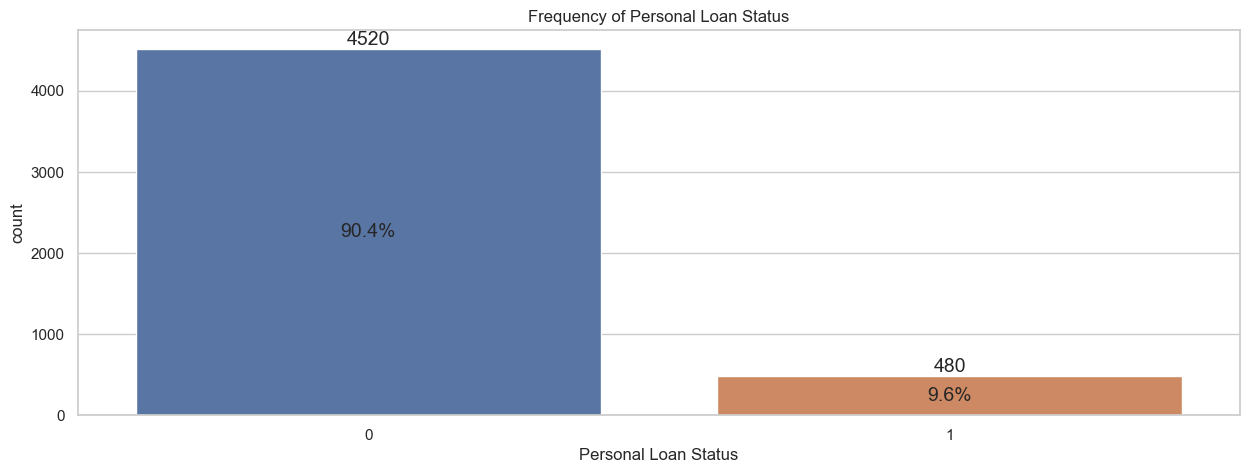

In [37]:
draw_countplot(df, 'Personal_Loan', label='Personal Loan Status')

📌 Points

- Only 9.6% (480) of customers have taken a personal loan
- The vast majority 90.4% (4520) of customers have not taken any personal loan
- This shows a significant imbalance in the target variable distribution


Observations 🔍

- The target variable Personal Loan is highly imbalanced, with only 9.6% of the samples opting for the loan (class 1).
- Decision Trees may struggle with class imbalance, as they tend to favor the majority class (0 in this case). This could result in the model predicting the majority class most of the time, thereby affecting performance metrics like precision, recall, and F1-score.
- This could lead to poor recall for class 1, as the tree may be biased toward predicting 0.

- Decision Trees are prone to overfitting, especially when there's a class imbalance. The tree might create deep branches for class 0 (the majority) to get perfect predictions, but struggle to generalize for class 1 (the minority).

- For accuracy, the model might seem to perform well just because it predicts class 0 correctly most of the time.

> Need to tune model (ie PrePruning) So as to mitigiate the effect of Imbalance in Target

Summary 

The Personal Loan column is imbalanced, and this could impact Decision Tree performance, particularly in predicting the minority class. Balancing the data and tuning the model will help improve the prediction accuracy for the minority class.

## BiVariate Analysis (EDA)

#### 1) Age & Income

In [11]:
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal_Loan', 'Securities_Account',
       'CD_Account', 'Online', 'CreditCard'],
      dtype='object')

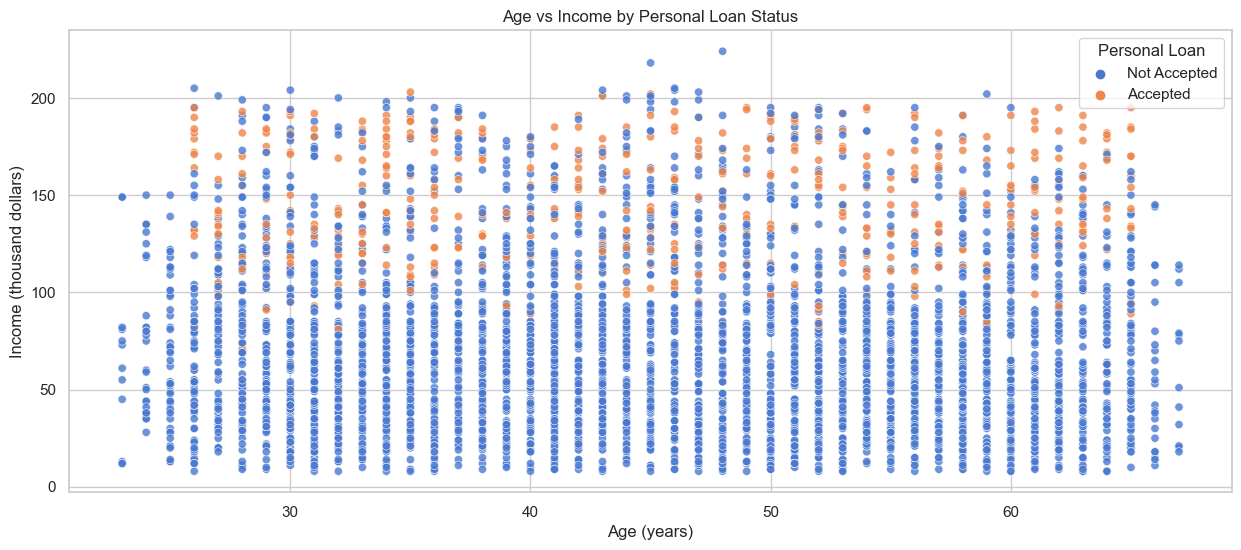

In [28]:
# Create scatter plot with better visibility
plt.figure(figsize=(15, 6))

# Use a more distinct color palette and increase point size
sns.scatterplot(data=df,
                x='Age',
                y='Income',
                hue='Personal_Loan',
                alpha=0.8,
                )  # Larger point size

plt.title('Age vs Income by Personal Loan Status')
plt.xlabel('Age (years)')
plt.ylabel('Income (thousand dollars)')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Not Accepted', 'Accepted'], title='Personal Loan')

plt.show()

In [14]:
# Optional: Add summary statistics by loan status
df.groupby('Personal_Loan')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Personal_Loan,,,,,,,,
0,4520.00,45.37,11.45,23.00,35.00,45.00,55.00,67.00
1,480.00,45.07,11.59,26.00,35.00,45.00,55.00,65.00


In [15]:
df.groupby('Personal_Loan')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Personal_Loan,,,,,,,,
0,4520.00,66.24,40.58,8.00,35.00,59.00,84.00,224.00
1,480.00,144.75,31.58,60.00,122.00,142.50,172.00,203.00


Key observations from Age vs Income analysis:

- No strong age-based pattern in loan acceptance

Income patterns:
- Clear income separation between loan acceptors and non-acceptors
- Non-acceptors (0):
  - Lower average income of ~$66,000
  - Wide income spread from $8,000 to $224,000
  - Most concentrated between $35,000-$84,000
- Loan acceptors (1): 
  - Much higher average income of ~$145,000
  - Narrower income range from $60,000 to $203,000
  - Most concentrated between $122,000-$172,000

Key insight:
- Income appears to be a much stronger predictor of loan acceptance than age
- **Higher income individuals (>$100k) are much more likely to accept personal loans**


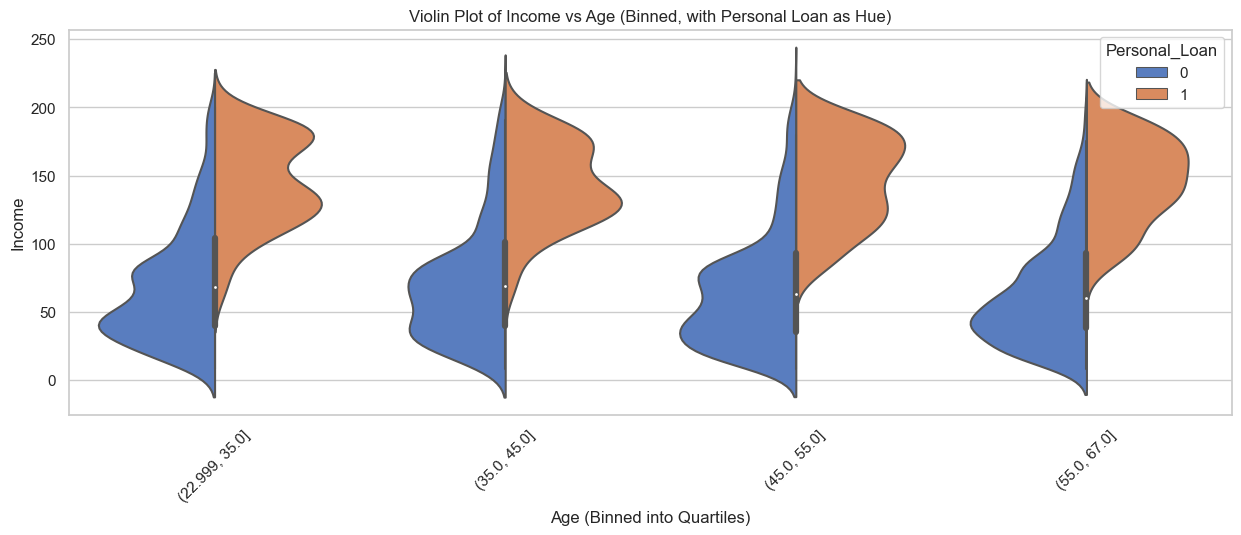

In [24]:
sns.violinplot(x=pd.qcut(df['Age'], q=4), y='Income', hue='Personal_Loan', data=df, split=True)

plt.title('Violin Plot of Income vs Age (Binned, with Personal Loan as Hue)')
plt.xlabel('Age (Binned into Quartiles)')
plt.ylabel('Income')
plt.xticks(rotation=45)
plt.show()

Observations 🔍

- For all age groups, higher income individuals (>$100k) are more likely to accept loans
- Income distributions are relatively similar across all age quartiles 
  - for older age groups, it's similar to Normal
- Each age group shows the clear separation between loan acceptors and non-acceptors
  - acceptors plots lie above median, in almost all the cases 
- The income threshold for loan acceptance appears fairly consistent across age groups
- Loan acceptors (1) show more compact, concentrated distributions
- Non-acceptors (0) show wider, skewed & more spread out distributions

> Decision Tree can find more balanced split points in case of acceptors as compared to non-acceptors because of comparatively good symmetric distribution

This reinforces that income is the dominant factor in loan acceptance,
while age plays a minimal role in the decision-making process


#### 2) FamilySize & Income

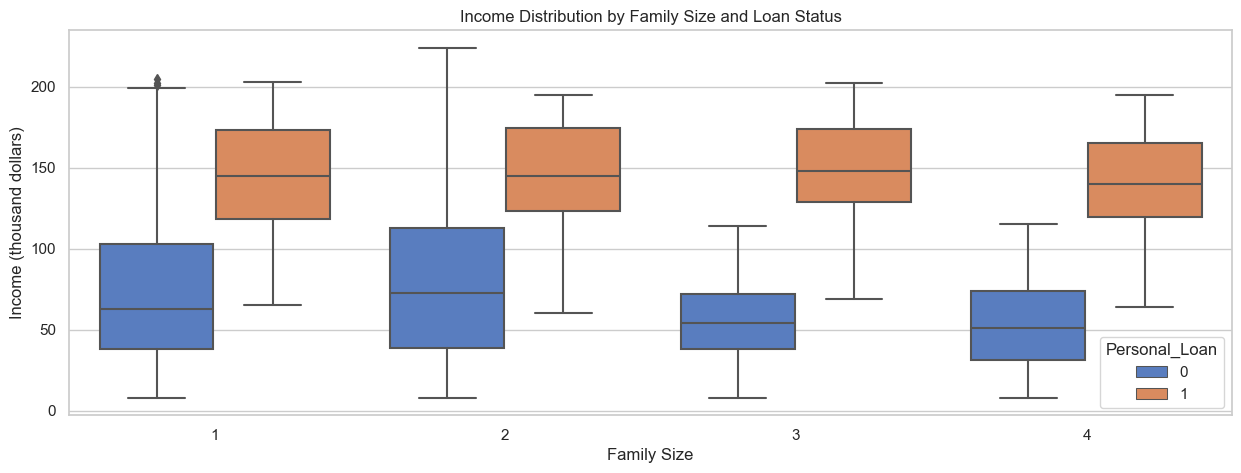

In [22]:
sns.boxplot(data=df,
           x='Family',
           y='Income',
           hue='Personal_Loan')

plt.title('Income Distribution by Family Size and Loan Status')
plt.xlabel('Family Size')
plt.ylabel('Income (thousand dollars)')

plt.show()

Observations 🔍:

1. Income is the key factor - loan acceptors consistently have higher incomes 
   ($140-150k) compared to non-acceptors ($60-70k) across all family sizes

2. Family size doesn't play a major role in loan acceptance - the income patterns
   stay similar whether someone has a small or large family

3. There's a clear income divide around $100k - people above this income level
   are much more likely to accept loans

4. The income spread is wider for those who don't take loans, suggesting other
   factors may influence their decision besides just income level


#### 3) Income & Credit Card Spend

In [18]:
df[['Income', 'CCAvg']].corr()

,Income,CCAvg
Income,1.00,0.65
CCAvg,0.65,1.00


Seems people with higher income tends to spend more on their credit card, probably

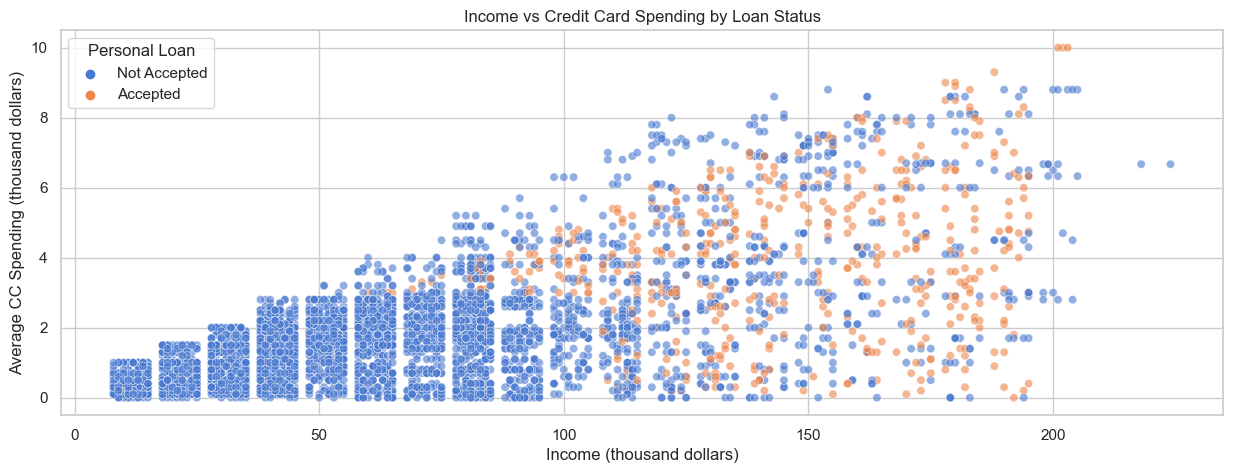

In [23]:
# Scatter plot of Income vs Credit Card Spending
sns.scatterplot(data=df,
                x='Income',
                y='CCAvg',
                hue='Personal_Loan',
                alpha=0.6)

plt.title('Income vs Credit Card Spending by Loan Status')
plt.xlabel('Income (thousand dollars)')
plt.ylabel('Average CC Spending (thousand dollars)')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Not Accepted', 'Accepted'], title='Personal Loan')

plt.show()

Observations :

1. Strong positive correlation (0.65) between income and credit card spending -
   as income increases, people tend to spend more on credit cards

2. Loan acceptors (orange dots) cluster in the higher income range (>$100k)
   and also tend to have higher credit card spending, comparatively

3. Non-acceptors (blue dots) are more spread out but concentrated in lower
   income and credit card spending ranges


📌 Based on above 3 analysis

**Income appears to be a strong differentiator between loan approval and rejection, indicating that it could be a key feature for decision splits in predicting personal loan eligibility.**

#### 4) Education & Personal Loan

In [37]:
pd.crosstab(df['Education'], df['Personal_Loan'])

Personal_Loan,0,1
Education,,
1,2003,93
2,1221,182
3,1296,205


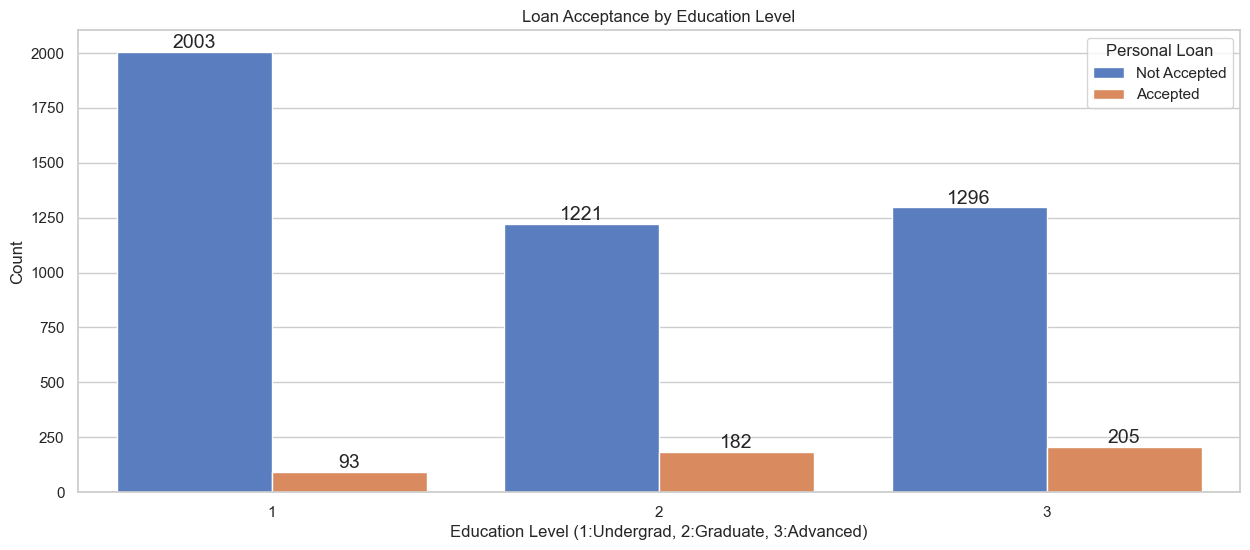

In [36]:
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df,
                  x='Education',
                  hue='Personal_Loan')

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container)

plt.title('Loan Acceptance by Education Level')
plt.xlabel('Education Level (1:Undergrad, 2:Graduate, 3:Advanced)')
plt.ylabel('Count')
plt.legend(title='Personal Loan', labels=['Not Accepted', 'Accepted'])

plt.show()

Observations:

1. Most customers are undergraduates (Education=1), but they have lowest loan acceptance rate
   - Out of 2096 undergrads, only 93 (4.4%) accepted loans
2. Professional (Education=3) show highest loan acceptance rate
   - Out of 1501 advanced degree holders, 205 (13.6%) accepted loans
   - This is 3x higher acceptance rate compared to undergrads
3. Graduate degree holders (Education=2) fall in middle
   - Out of 1403 graduates, 182 (13%) accepted loans

Key Insight for Decision Tree ⚡:
- Education level could be a good splitting criterion since there's clear difference
  in loan acceptance rates between education levels
- Advanced/Graduate degree holders are more likely to accept loans compared to undergrads
- This makes intuitive sense as higher education often correlates with higher income
  and better financial literacy


#### 5) Mortgage vs Personal Loan

In [54]:
# get idea about skew of mortgage
df['Mortgage'].skew()

2.1040023191079444

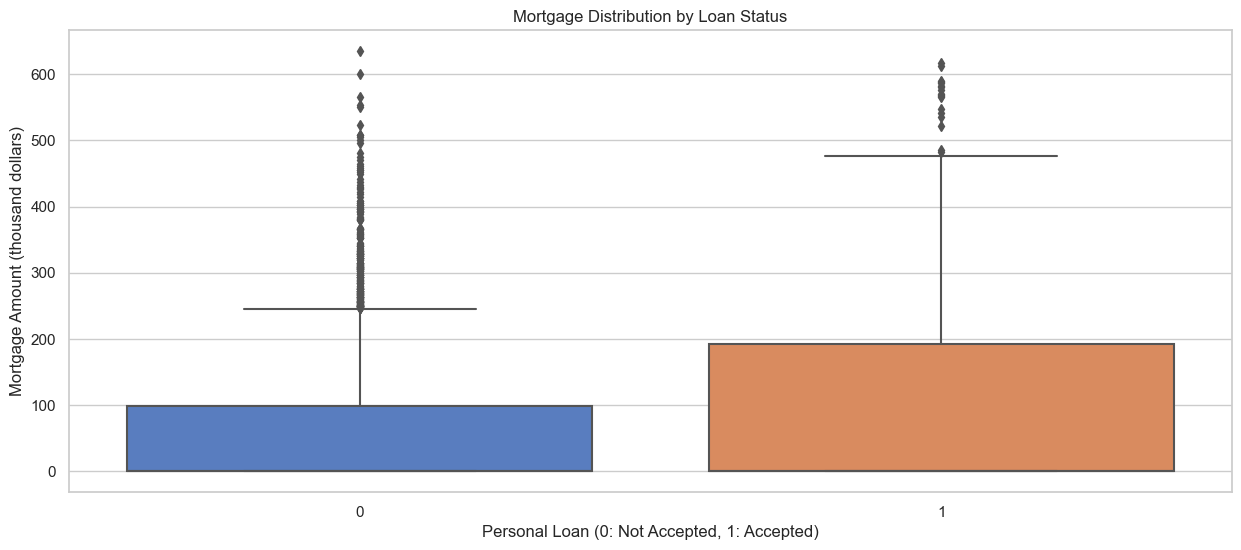

In [60]:
plt.figure(figsize=(15, 6))

# Box plot to show mortgage distribution by loan status
sns.boxplot(data=df,
           x='Personal_Loan',
           y='Mortgage',
           order=[0, 1])

plt.title('Mortgage Distribution by Loan Status')
plt.xlabel('Personal Loan (0: Not Accepted, 1: Accepted)')
plt.ylabel('Mortgage Amount (thousand dollars)')

plt.show()

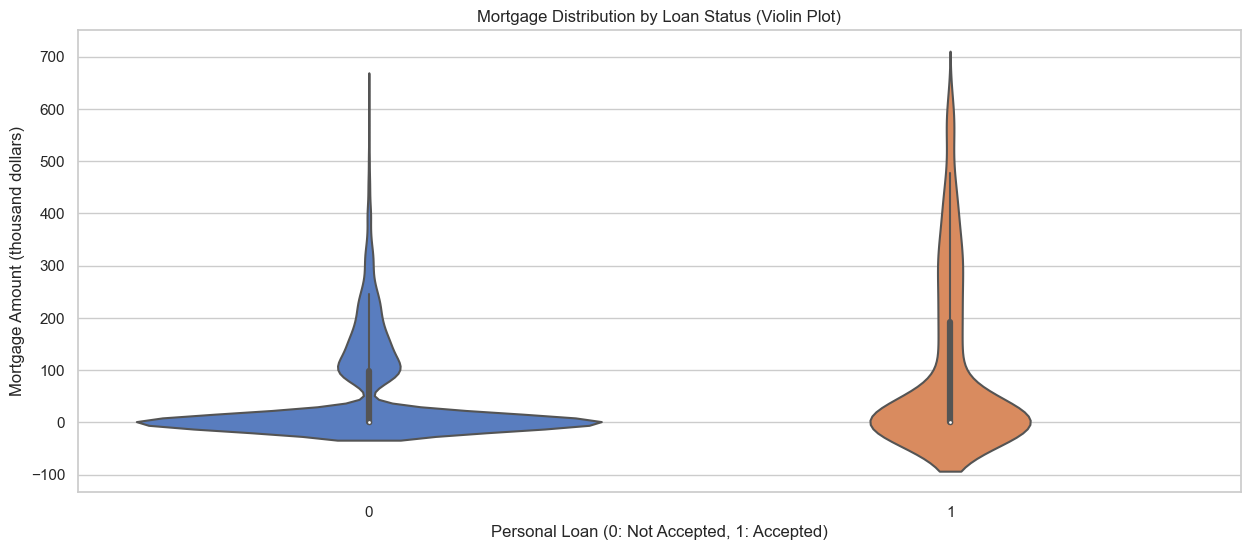

In [59]:
# Create violin plot
plt.figure(figsize=(15, 6))

sns.violinplot(data=df,
              x='Personal_Loan',
              y='Mortgage',
              order=[0, 1])

plt.title('Mortgage Distribution by Loan Status (Violin Plot)')
plt.xlabel('Personal Loan (0: Not Accepted, 1: Accepted)')
plt.ylabel('Mortgage Amount (thousand dollars)')

plt.show()

Heavy tail (ie many outliers)

In [55]:
# fraction of people who didnt took loan but have mortgage > 0
df[(df['Personal_Loan'] == 0) & (df['Mortgage'] > 0)].shape[0] / df[df['Mortgage'] > 0].shape[0]


0.8907672301690507

In [56]:
# fraction of people who took loan but have mortgage > 0
df[(df['Personal_Loan'] == 1) & (df['Mortgage'] > 0)].shape[0] / df[df['Mortgage'] > 0].shape[0]


0.10923276983094929

In [48]:
# fraction of people who didnt took loan when mortgage is > 500
df[(df['Personal_Loan'] == 0) & (df['Mortgage'] > 500)].shape[0] / df[df['Mortgage'] > 500].shape[0]


0.36

In [49]:
# fraction of people who took loan when mortgage is > 500
df[(df['Personal_Loan'] == 1) & (df['Mortgage'] > 500)].shape[0] / df[df['Mortgage'] > 500].shape[0]


0.64

In [53]:
# if person accept loan, their mortgage stats
tb_describe(df[df['Personal_Loan'] == 1]['Mortgage'])

            count    mean     std    min    25%    50%     75%     max
--------  -------  ------  ------  -----  -----  -----  ------  ------
Mortgage   480.00  100.85  160.85   0.00   0.00   0.00  192.50  617.00


Observations:

1. Most customers who accepted loans have low (ie less than $200K) or no mortgage
2. 89% of customers who have mortgages, didnt took loan (ie only 10% of them took loan)
3. However, It seems that when mortgage is high (ie >$500K), people use to accept Loans

Insights for Decision Tree: 
- Mortgage data is highly skewed (skewness = 2.1), hence classifier may create seperate branches
- The spread of Mortgage is wide in both classes, making it less useful for clear splits.
- Since outliers exist in both categories, Mortgage alone may not be a strong decision-making feature.

**This suggests having a mortgage may make customers less likely to take personal loans**

#### 6) Securities Account & Personal Loan Acceptance

In [89]:
# personal loan acceptance when possess securities account
df[df['Securities_Account'] == 1]['Personal_Loan'].value_counts()

0    462
1     60
Name: Personal_Loan, dtype: int64

In [91]:
# personal loan acceptance when not possess securities account
df[df['Securities_Account'] == 0]['Personal_Loan'].value_counts()

0    4058
1     420
Name: Personal_Loan, dtype: int64

<Figure size 1500x600 with 0 Axes>

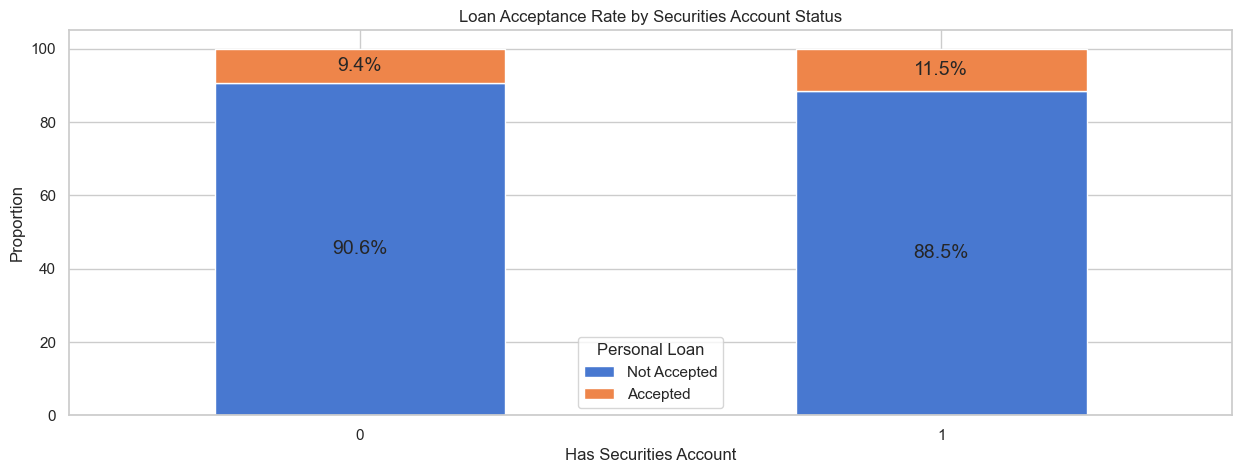

In [81]:
# stacked bar chart
plt.figure(figsize=(15, 6))

#cross-tabulation
(pd.crosstab(df['Securities_Account'], df['Personal_Loan'], normalize='index') * 100).plot(
    kind='bar',
    stacked=True,
    rot=0 # Set rotation to 0 to keep x-ticks horizontal
)

plt.title('Loan Acceptance Rate by Securities Account Status')
plt.xlabel('Has Securities Account')
plt.ylabel('Proportion')
plt.legend(title='Personal Loan', labels=['Not Accepted', 'Accepted'])

# Add percentage labels
for c in plt.gca().containers:
    plt.bar_label(c, fmt='%.1f%%', label_type='center')

plt.show()

Observations: 
- Most customers (4,478) don't have a Securities Account, while only 522 do
- Having a Securities Account doesn't seem to make much difference in whether customers accept or reject the loan offer
- Overall, Securities Account status alone is not a strong predictor of loan
  acceptance, as the difference in acceptance rates is relatively small


#### 7) Online Banking & Personal Loan Acceptance

<Figure size 1000x600 with 0 Axes>

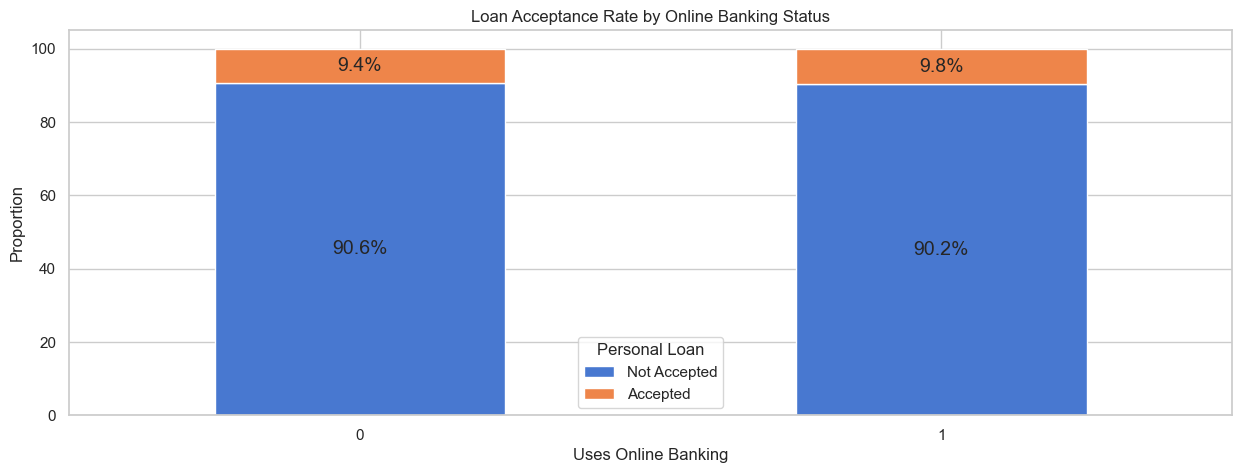

In [83]:
# Create stacked bar chart
plt.figure(figsize=(10, 6))

# Create cross-tabulation with percentages
(pd.crosstab(df['Online'], df['Personal_Loan'], normalize='index') * 100).plot(
    kind='bar',
    stacked=True,
    rot=0
)

plt.title('Loan Acceptance Rate by Online Banking Status')
plt.xlabel('Uses Online Banking')
plt.ylabel('Proportion')
plt.legend(title='Personal Loan', labels=['Not Accepted', 'Accepted'])

# Add percentage labels
for c in plt.gca().containers:
    plt.bar_label(c, fmt='%.1f%%', label_type='center')

plt.show()

In [94]:
# fraction of customer who use online banking and accepted loan
val = df[(df['Online'] == 1) & (df['Personal_Loan'] == 1)].shape[0] / df[df['Online'] == 1].shape[0]
to_percentage(val)


'9.8%'

In [95]:
# fraction of customer who dont use online banking and accepted loan
val = df[(df['Online'] == 0) & (df['Personal_Loan'] == 1)].shape[0] / df[df['Online'] == 0].shape[0]
to_percentage(val)

'9.4%'

Points 📌

- Online Banking seems to have minimal impact on the likelihood of accepting a Personal Loan, as both sides are showing similar behavior for concern in crux

Observations 🔍

- Among customers who use online banking, around 9.8% accepted personal loans
- For customers who don't use online banking, about 9.4% accepted personal loans
- The difference in acceptance rates between online and non-online banking users is negligible
- This suggests that online banking usage is not a strong predictor of personal loan acceptance
- The bank may not need to focus on online banking status when targeting customers for personal loan marketing

#### 8) CCAvg & Mortgage

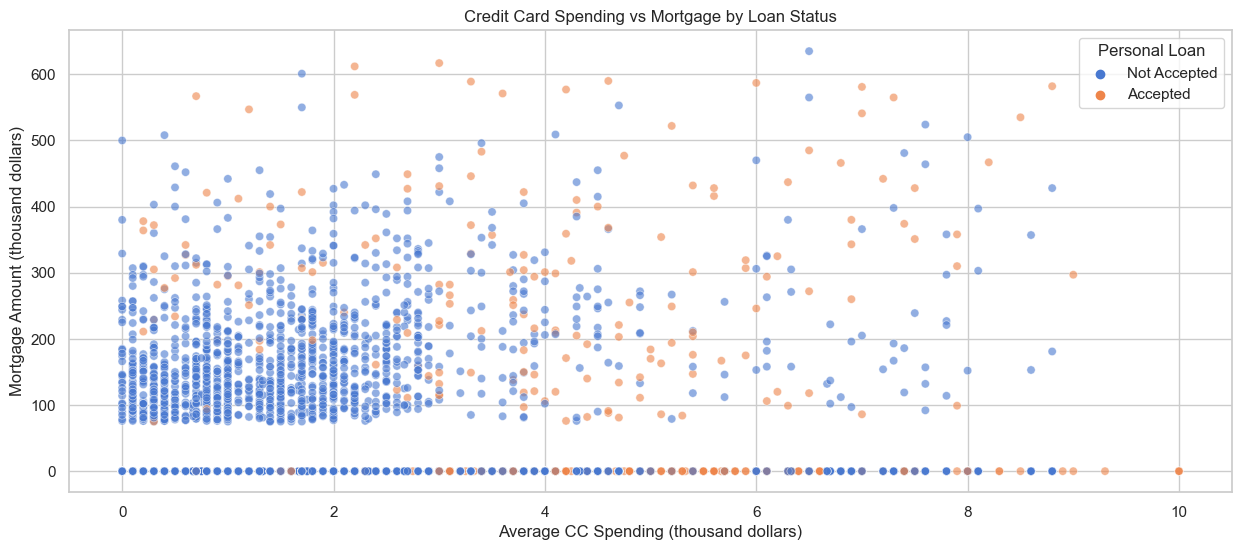

In [109]:
# Scatter plot of CCAvg vs Mortgage colored by Personal Loan
plt.figure(figsize=(15, 6))

sns.scatterplot(data=df,
                x='CCAvg',
                y='Mortgage',
                hue='Personal_Loan',
                alpha=0.6)

plt.title('Credit Card Spending vs Mortgage by Loan Status')
plt.xlabel('Average CC Spending (thousand dollars)')
plt.ylabel('Mortgage Amount (thousand dollars)')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Not Accepted', 'Accepted'], title='Personal Loan')

plt.show()

Observation :

- Many people are there who took small loan for house and are conservative in their credit card expenditure
- Many people dont have house loans but still uses credit card
- Even though people have moderate mortgage, they soundly spend on their credit card and might accept the personal loan to balance it out

In [100]:
df['Mortgage'].describe()

count   5000.00
mean      56.50
std      101.71
min        0.00
25%        0.00
50%        0.00
75%      101.00
max      635.00
Name: Mortgage, dtype: float64

In [112]:
# people who have low mortgage and high spending on credit card
df[(100 <= df['Mortgage']) & (df['Mortgage'] <= 500) & (df['CCAvg'] > 1)]['Personal_Loan'].value_counts()

0    659
1    123
Name: Personal_Loan, dtype: int64

Approximately 20% of them accepted the personal loan, while having medium house loans

In [108]:
# people who have high mortgage and high spending on credit card
df[ (df['Mortgage'] > 500) & (df['CCAvg'] > 1)]['Personal_Loan'].value_counts()

1    15
0     8
Name: Personal_Loan, dtype: int64

**50% of people with high mortagage and high spending on credit card choose to go for Personal Loan**

In [107]:
# people who have low mortgage and low spending on credit card
df[(df['Mortgage'] < 100) & (df['CCAvg'] < 1)]['Personal_Loan'].value_counts()

0    1244
1      31
Name: Personal_Loan, dtype: int64

NOTE: 
> We focused on visualizations that directly aid in understanding potential decision splits, rather than using methods like HeatMaps which might not offer the same clarity for decision tree modeling.

---

## Bake Fresh Data 

Why ? 

As earlier in analysis part, if df got modified, we dont want such alterations to start with preprocessing

In [10]:
df = df_original.copy()

In [11]:
# verify that df is different ie copied of original and will not modify original by any means
id(df) == id(df_original)

False

---

## Data PreProcessing

#### Experience 

Earlier we saw experience has -ve values

In [12]:
# people with -ve experience
neg_exp_df = df[df['Experience'] < 0]

In [13]:
neg_exp_df.shape[0]

52

There are 52 people with -ve experience

Idea & Explore 🧠:

Generally, people gained experience as they aged

- If Experience is mistakenly recorded with a negative sign (for example, because of a data entry error), you would expect that Experience and Age might show a strong negative correlation (the older the person, the less experience they have) or weak positive relation (this maybe due to less observations) (ie experience increases with age but due to -ve sign its weakened).

- In an ideal scenario, Experience and Age should show a positive correlation: as a person's age increases, their work experience should typically increase. If the correlation is strongly negative or close to zero, it might suggest that something went wrong in the data entry (i.e., the negative sign was added by mistake).

In [14]:
# Overall correlations
print("Overall correlations:")
print(df[['Age', 'Experience', 'Income']].corr())

# Correlations for positive experience cases
print("\nCorrelations for positive experience cases:")
print(df[df['Experience'] >= 0][['Age', 'Experience', 'Income']].corr())

# Correlations for negative experience cases
print("\nCorrelations for negative experience cases:")
print(df[df['Experience'] < 0][['Age', 'Experience', 'Income']].corr())


Overall correlations:
             Age  Experience  Income
Age         1.00        0.99   -0.06
Experience  0.99        1.00   -0.05
Income     -0.06       -0.05    1.00

Correlations for positive experience cases:
             Age  Experience  Income
Age         1.00        0.99   -0.06
Experience  0.99        1.00   -0.05
Income     -0.06       -0.05    1.00

Correlations for negative experience cases:
             Age  Experience  Income
Age         1.00        0.31   -0.07
Experience  0.31        1.00   -0.14
Income     -0.07       -0.14    1.00


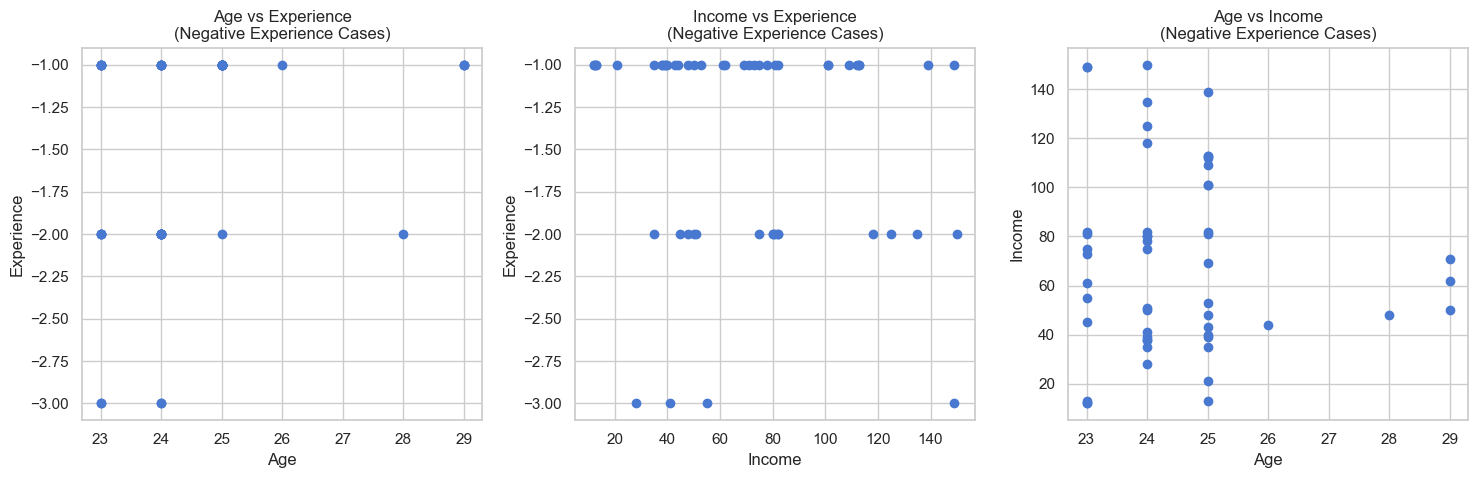


Summary of negative experience cases:
        Age  Experience  Income
count 52.00       52.00   52.00
mean  24.52       -1.44   69.94
std    1.48        0.64   37.96
min   23.00       -3.00   12.00
25%   24.00       -2.00   40.75
50%   24.00       -1.00   65.50
75%   25.00       -1.00   86.75
max   29.00       -1.00  150.00


In [15]:
# Create scatter plots
plt.figure(figsize=(15, 5))

# Plot 1: Age vs Experience for negative cases
plt.subplot(1, 3, 1)
plt.scatter(neg_exp_df['Age'], neg_exp_df['Experience'])
plt.xlabel('Age')
plt.ylabel('Experience')
plt.title('Age vs Experience\n(Negative Experience Cases)')

# Plot 2: Income vs Experience for negative cases
plt.subplot(1, 3, 2)
plt.scatter(neg_exp_df['Income'], neg_exp_df['Experience'])
plt.xlabel('Income')
plt.ylabel('Experience')
plt.title('Income vs Experience\n(Negative Experience Cases)')

# Plot 3: Age vs Income for negative cases
plt.subplot(1, 3, 3)
plt.scatter(neg_exp_df['Age'], neg_exp_df['Income'])
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Age vs Income\n(Negative Experience Cases)')

plt.tight_layout()
plt.show()

# Print summary statistics for negative experience cases
print("\nSummary of negative experience cases:")
print(neg_exp_df[['Age', 'Experience', 'Income']].describe())

- Experience ranges from 1 <-> 3 (ie absolute values)
- Negative experience cases occur mostly with younger customers (age 23-29)
  - This suggests they are likely entry-level.
- Moreover for income, 
  - people with -1 years experience, income lies in slab 40k to 80k 
  - people with -2 years experience, median typically falls around 80K

- As -ve experience ranges from 1 to 3 & customers seems to be entry-level, this go hand in hand and insinuate that -ve sign was added by mistake because generally entry-level is associated with 1 to 3 levels of experience

- Moreover The income of individuals with negative experience is in line with entry-level salaries, ranging from 40K to 80K or higher, which is consistent with people having 1-2 years of experience (but not negative experience).


> There is a reasonable assumption that the negative sign might have been a data entry mistake, where a user or system mistakenly entered -1 instead of 1, and similarly for other negative values

**Hence, By applying abs(), you are essentially correcting a data entry error**

In [16]:
# Take absolute value of Experience
df['Experience'] = df['Experience'].abs()

In [17]:
# Verify the change
tb_describe(df['Experience'])

              count    mean    std    min    25%    50%    75%    max
----------  -------  ------  -----  -----  -----  -----  -----  -----
Experience  5000.00   20.13  11.42   0.00  10.00  20.00  30.00  43.00


In [18]:
(df['Experience'] < 0).sum()

0

#### Discard ZipCode & ID

Why ZIP Code is discarded ?

1. **No Direct Influence on Loan Acceptance** – ZIP codes represent geographic locations, but they don’t directly impact a customer's financial behavior or likelihood of accepting a loan.

2. **Too Granular & High Cardinality** – Since ZIP codes are categorical but unique to regions, they create too many categories with little predictive power.

3. **Privacy & Ethical Concerns** – Using ZIP codes for loan predictions may introduce bias based on location demographics rather than individual financial behavior.

4. **Not Useful for Marketing** – The bank’s goal is to predict who will take a loan, not where they live. Location-based targeting might be relevant in some cases, but it's unlikely to be the key driver in personal loan acceptance.

Why ID discarded ?

ID is just a unique identifier (ie **Nominal** value) with no predictive value

In [19]:
# Drop ID and ZIP code columns
df = df.drop(['ID', 'ZIPCode'], axis=1)

**Education**

There is natural hierarchy/progression in education levels
1. Undergrad < Graduate < Advanced/Professional
2. Each one typically build upon the previous one
3. Hence the numeric coding may represent increasing levels of education

Therefore lets treat Education as an ordinal data

> The natural ordering could be informative for predictive loan acceptance


**Feature Engineering**

Should we do OHE for { Securities_Account, CD_Account, Online, CreditCard } as all of them are categorical in nature ?

-> Theoritically yes, but here not required as all of them are binary (ie either 0 0r 1)

Why ?? 

1. Decision Tree Splitting Mechanism:
- Decision trees work by finding optimal split points in features
- For a binary variable, there's only one possible split point (between 0 and 1)
- The tree doesn't treat this as an ordinal relationship - it simply groups all 0s in one node and all 1s in another

2. Important Distinction:
- While it's true that 0 and 1 are numeric values, the decision tree algorithm doesn't utilize their numeric ordering
- The tree only cares about splitting the data into two groups, which is exactly what these binary values already represent

**For binary variables, there's no risk of ordinal interpretation since there are only two values. The classifier will effectively treat them as two distinct categories regardless of whether they're 0/1 or one-hot encoded.**


**Outlier**



In [21]:
# Check outliers in numerical columns using boxplots statistics
numerical_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']

# Calculate outlier statistics using IQR method
outlier_stats = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

    outlier_stats[col] = {
        'outlier_count': len(outliers),
        'outlier_percentage': (len(outliers) / len(df)) * 100,
        'min': df[col].min(),
        'max': df[col].max()
    }

# Display outlier statistics
for col, stats in outlier_stats.items():
    print(f"\n{col}:")
    print(f"Number of outliers: {stats['outlier_count']}")
    print(f"Percentage of outliers: {stats['outlier_percentage']:.2f}%")
    print(f"Range: {stats['min']} to {stats['max']}")


Age:
Number of outliers: 0
Percentage of outliers: 0.00%
Range: 23 to 67

Experience:
Number of outliers: 0
Percentage of outliers: 0.00%
Range: 0 to 43

Income:
Number of outliers: 96
Percentage of outliers: 1.92%
Range: 8 to 224

CCAvg:
Number of outliers: 324
Percentage of outliers: 6.48%
Range: 0.0 to 10.0

Mortgage:
Number of outliers: 291
Percentage of outliers: 5.82%
Range: 0 to 635


Age:
Number of outliers: 0
Percentage of outliers: 0.00%
Range: 23 to 67

Experience:
Number of outliers: 0
Percentage of outliers: 0.00%
Range: 0 to 43

Income:
Number of outliers: 96
Percentage of outliers: 1.92%
Range: 8 to 224

CCAvg:
Number of outliers: 324
Percentage of outliers: 6.48%
Range: 0.0 to 10.0

Mortgage:
Number of outliers: 291
Percentage of outliers: 5.82%
Range: 0 to 635



In [22]:
df_original.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.00,2500.50,1443.52,1.00,1250.75,2500.50,3750.25,5000.00
Age,5000.00,45.34,11.46,23.00,35.00,45.00,55.00,67.00
Experience,5000.00,20.10,11.47,-3.00,10.00,20.00,30.00,43.00
Income,5000.00,73.77,46.03,8.00,39.00,64.00,98.00,224.00
ZIPCode,5000.00,93169.26,1759.46,90005.00,91911.00,93437.00,94608.00,96651.00
Family,5000.00,2.40,1.15,1.00,1.00,2.00,3.00,4.00
CCAvg,5000.00,1.94,1.75,0.00,0.70,1.50,2.50,10.00
Education,5000.00,1.88,0.84,1.00,1.00,2.00,3.00,3.00
Mortgage,5000.00,56.50,101.71,0.00,0.00,0.00,101.00,635.00
Personal_Loan,5000.00,0.10,0.29,0.00,0.00,0.00,0.00,1.00


⚡ Key Findings 

1. Age (23-67 years):
   - Normal distribution with minimal outliers
   - Range is reasonable for working population

2. Experience (-3 to 43 years):
   - Only concerning outliers are negative values 
   - Which is already handled

3. Income ($8K-$224K):
   - Right-skewed but expected for income data
   - High values represent legitimate wealthy customers

4. CCAvg ($0-$10K monthly):
   - Right-skewed, correlates with income
   - High spenders are valid data points

5. Mortgage ($0-$635K):
   - Many zeros (no mortgage)
   - Large values are normal for property loans

**Summary:** Only negative experience values need treatment. Other outliers are valid data points.


The Decision tree naturally handle outliers through their splitting mechanism. Unlike algorithms like linear regression or k-means clustering, trees don't get distorted by extreme values. The tree will simply create split that isolate these outlier values when needed

Hence we can save processing time & skip such step:
- Capping/Flooring values
- Removing outliers
- Transforming outliers
- Winsorization
- Any other outlier treatment methods

In [23]:
df_processed = df.copy()

---

## Modelling

#### Python Utils

In [51]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def get_classification_metrics(y, y_pred):
    """
    Function to compute different metrics to check classification model performance

    Parameters:
        y: array-like of shape (n_samples,), dependent variable/ground truth labels
        y_pred: array-like of shape (n_samples,), predicted target values

    Returns:
        pd.DataFrame containing model performance metrics (Accuracy, Recall, Precision, F1)
    """
    # compute various metrics
    acc = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
        },
        index=[0]
    )

    return df_perf

In [88]:
def plot_confusion_matrix(y, y_pred):
    """
    To plot the confusion_matrix with percentages

    y: true target values
    y_pred: predicted target values
    """
    # Compute the confusion matrix comparing the true target values with the predicted values
    cm = confusion_matrix(y, y_pred)

    # Create labels for each cell in the confusion matrix with both count and percentage
    total = cm.flatten().sum()
    labels = np.asarray(
        [
            [f"{item:0.0f}\n{item/total:.2%}"]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)    # reshaping to a matrix

    # Set the figure size for the plot
    plt.figure(figsize=(6, 4))

    # Plot the confusion matrix as a heatmap with the labels
    sns.heatmap(cm, annot=labels, fmt="", cmap="RdPu")

    # Add a label to the y-axis
    plt.ylabel("True label")

    # Add a label to the x-axis
    plt.xlabel("Predicted label")

In [110]:
def get_tree_stats(tree):
    """Helper function to get tree complexity statistics

    Args:
        tree: Fitted decision tree model

    Returns:
        None - prints tree statistics
    """
    print("Tree Statistics:")
    print(f"Number of nodes: {tree.tree_.node_count}")
    print(f"Tree depth: {tree.get_depth()}")

In [112]:
def get_feature_importances(model, X):
    """
    Get feature importances from a trained model.

    Args:
        model: Trained model with feature_importances_ attribute
        X: Features dataframe used for training

    Returns:
        DataFrame with feature names and their importance scores, sorted by importance
    """
    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    return importances

In [146]:
def plot_decision_tree(model, X, figsize=(20,20), fontsize=9):
    """Helper function to plot a decision tree with formatted arrows

    Args:
        model: Fitted decision tree model
        X: Features dataframe used for training
        figsize: Figure size tuple (width, height)
        fontsize: Font size for node text

    Returns:
        None - displays the plot
    """
    # get feature names
    feature_names = list(X.columns)

    # create figure
    plt.figure(figsize=figsize)

    # plot decision tree
    out = tree.plot_tree(
        model,
        feature_names=feature_names,
        filled=True,
        fontsize=fontsize,
        node_ids=False,
        class_names=None
    )

    # format arrows
    for o in out:
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor("black")
            arrow.set_linewidth(1)

    plt.show()

In [147]:
def print_tree_rules(model, feature_names):
    """Helper function to print a text report showing the rules of a decision tree

    Args:
        model: Fitted decision tree model
        feature_names: List of feature names used in the model

    Returns:
        None - prints the tree rules
    """
    print(
        tree.export_text(
            model,
            feature_names=feature_names,
            show_weights=True
        )
    )

### Data Preparation for Modelling

In [24]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   Family              5000 non-null   int64  
 4   CCAvg               5000 non-null   float64
 5   Education           5000 non-null   int64  
 6   Mortgage            5000 non-null   int64  
 7   Personal_Loan       5000 non-null   int64  
 8   Securities_Account  5000 non-null   int64  
 9   CD_Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 468.9 KB


In [27]:
X = df_processed.drop('Personal_Loan', axis=1)
y = df_processed['Personal_Loan']

# perform train test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Train Data
# total samples in train data
print(f"Total samples in train data: {X_train.shape[0]} = (80%)")

Total samples in train data: 4000 = (80%)


In [31]:
# Test Data
print(f"Total samples in test data: {X_test.shape[0]} = (20%)")

Total samples in test data: 1000 = (20%)


In [37]:
# target class distribution
print("Target class distribution in train data:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

print("\nTarget class distribution in test data:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

Target class distribution in train data:
0    3625
1     375
Name: Personal_Loan, dtype: int64
0    90.62%
1     9.38%
Name: Personal_Loan, dtype: object

Target class distribution in test data:
0    895
1    105
Name: Personal_Loan, dtype: int64
0    89.5%
1    10.5%
Name: Personal_Loan, dtype: object


Seems 90 : 10 distribution of target class (ie Personal Loan Acceptance). 

So, for every person who accepts the loan (1), there are about 9 people who do not accept the loan (0) in both train and test splits.

### Model building

In [46]:
SEED = 42

#### Decision Tree (default)

In [99]:
# classifier
dt_default = DecisionTreeClassifier(random_state=SEED)
# fit the model
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [100]:
dt_default.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [101]:
# predict on train data
y_train_pred = dt_default.predict(X_train)

In [102]:
# predict on test data
y_test_pred = dt_default.predict(X_test)

Training Evaluation

In [103]:
# training performance metrics
get_classification_metrics(y_train, y_train_pred)

,Accuracy,Recall,Precision,F1
0,1.00,1.00,1.00,1.00


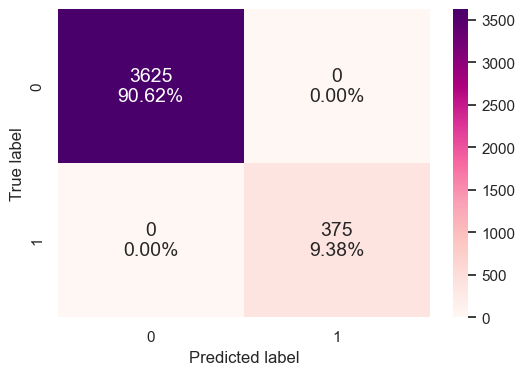

In [104]:
# training confusion matrix
plot_confusion_matrix(y_train, y_train_pred)

In [105]:
# evaluate the model
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3625
           1       1.00      1.00      1.00       375

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



Test Evaluation

In [106]:
# testing performance metrics
get_classification_metrics(y_test, y_test_pred)

,Accuracy,Recall,Precision,F1
0,0.99,0.93,0.95,0.94


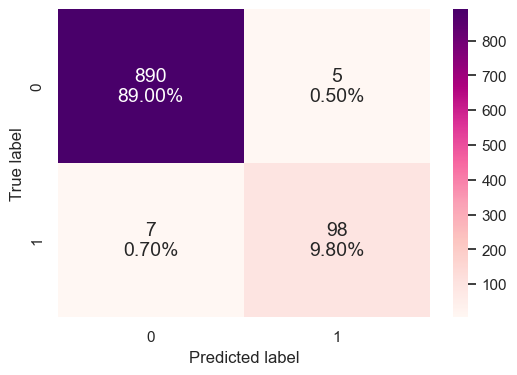

In [107]:
# testing confusion matrix
plot_confusion_matrix(y_test, y_test_pred)

In [108]:
# evaluate the model
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       895
           1       0.95      0.93      0.94       105

    accuracy                           0.99      1000
   macro avg       0.97      0.96      0.97      1000
weighted avg       0.99      0.99      0.99      1000



In [111]:
# Check tree complexity
get_tree_stats(dt_default)

Tree Statistics:
Number of nodes: 125
Tree depth: 13


In [114]:
X_train.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard'],
      dtype='object')

In [152]:
# Get and display feature importances
importances_default = get_feature_importances(dt_default, X_train)
print("\nFeature Importances:")
print(importances_default)


Feature Importances:
               feature  importance
5            Education        0.38
2               Income        0.30
3               Family        0.18
4                CCAvg        0.05
1           Experience        0.03
0                  Age        0.02
9               Online        0.02
8           CD_Account        0.01
6             Mortgage        0.01
10          CreditCard        0.00
7   Securities_Account        0.00


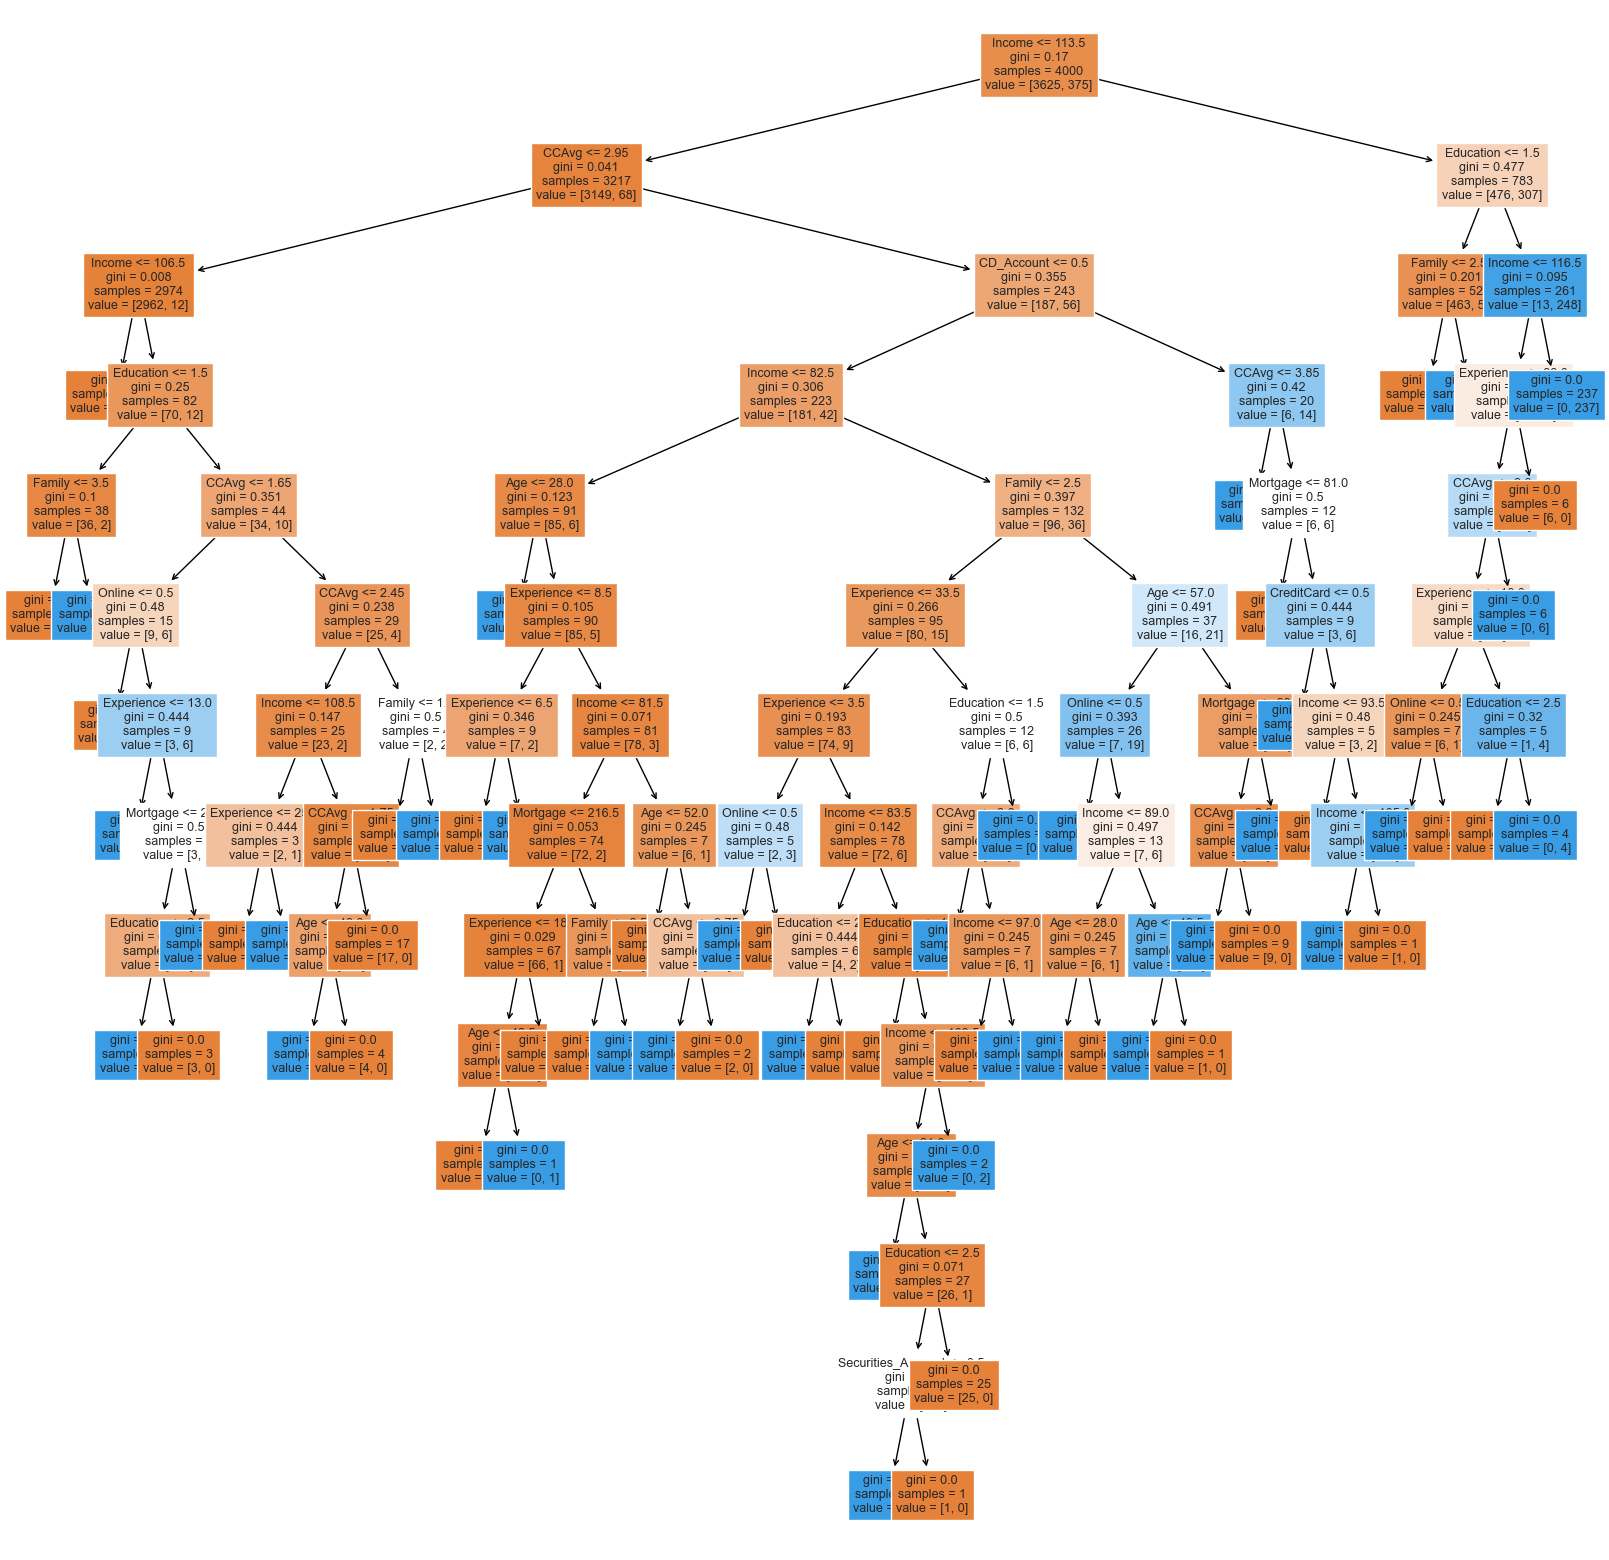

In [148]:
plot_decision_tree(dt_default, X_train)

In [149]:
print_tree_rules(dt_default, X_train.columns)

|--- Income <= 113.50
|   |--- CCAvg <= 2.95
|   |   |--- Income <= 106.50
|   |   |   |--- weights: [2892.00, 0.00] class: 0
|   |   |--- Income >  106.50
|   |   |   |--- Education <= 1.50
|   |   |   |   |--- Family <= 3.50
|   |   |   |   |   |--- weights: [36.00, 0.00] class: 0
|   |   |   |   |--- Family >  3.50
|   |   |   |   |   |--- weights: [0.00, 2.00] class: 1
|   |   |   |--- Education >  1.50
|   |   |   |   |--- CCAvg <= 1.65
|   |   |   |   |   |--- Online <= 0.50
|   |   |   |   |   |   |--- weights: [6.00, 0.00] class: 0
|   |   |   |   |   |--- Online >  0.50
|   |   |   |   |   |   |--- Experience <= 13.00
|   |   |   |   |   |   |   |--- weights: [0.00, 3.00] class: 1
|   |   |   |   |   |   |--- Experience >  13.00
|   |   |   |   |   |   |   |--- Mortgage <= 206.00
|   |   |   |   |   |   |   |   |--- Education <= 2.50
|   |   |   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |   |   |   |--- Education >  2.50
|   |   |   |   | 

Results are quite surprising with default model

Lets check target variable imbalancedness 

In [97]:
# Check target variable imbalancedness
df_original['Personal_Loan'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

0    90.4%
1     9.6%
Name: Personal_Loan, dtype: object

NOTE 📌

Data is highly imbalanced (90% vs 10%). This makes high metrics bit suspicious.

With such imbalanced data:

1. High Accuracy (99%) can be misleading because:
   - Model could simply predict "Not Accepted" everytime
   - Would still get 90% accuracy without learning anything !

2. The high Recall (93%), Precision(95%), F1(94%) for imbalanced data suggests:
   - Possible data leakage
   - Or oversampling/undersampling was done incorrectly 
   - Or test set isn't representative

So Let's try with weightage

#### Decision Tree (Weightage)

In [116]:
# tree with balanced class weights

# classifier
dt_balanced = DecisionTreeClassifier(
    random_state=SEED,
    class_weight='balanced'  # Simply use 'balanced' instead of explicit weights
)
# train the model
dt_balanced.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [117]:
dt_balanced.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [118]:
# predict on train data
y_train_pred = dt_balanced.predict(X_train)
# predict on test data
y_test_pred = dt_balanced.predict(X_test)

Training Evaluation

In [119]:
# get performance metrics
get_classification_metrics(y_train, y_train_pred)

,Accuracy,Recall,Precision,F1
0,1.00,1.00,1.00,1.00


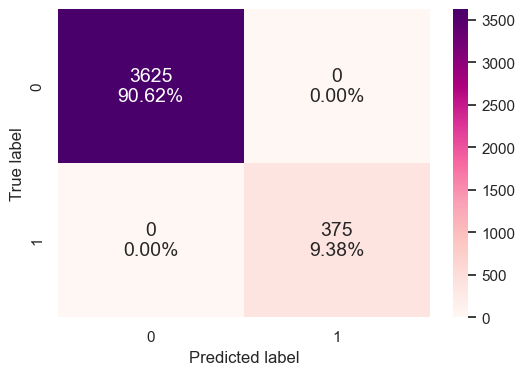

In [120]:
# get confusion matrix
plot_confusion_matrix(y_train, y_train_pred)

In [122]:
# evaluate the model
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3625
           1       1.00      1.00      1.00       375

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



Testing Evaluation

In [123]:
# get performance metrics
get_classification_metrics(y_test, y_test_pred)

,Accuracy,Recall,Precision,F1
0,0.99,0.92,0.96,0.94


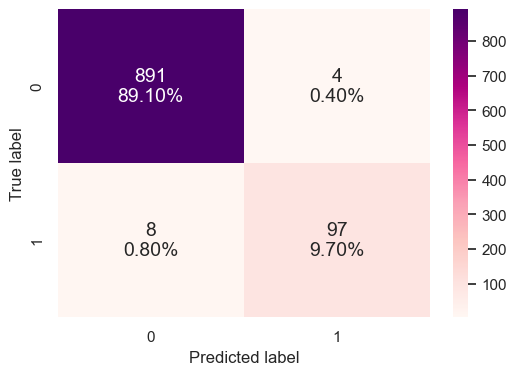

In [124]:
# get confusion matrix
plot_confusion_matrix(y_test, y_test_pred)

In [125]:
# evaluate the model
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       895
           1       0.96      0.92      0.94       105

    accuracy                           0.99      1000
   macro avg       0.98      0.96      0.97      1000
weighted avg       0.99      0.99      0.99      1000



- Model is already doing well on training and testing datasets
- Between default and balanced there is not major improvements (hence imbalanced things doesn't bother considerably & seems to be reasonable)

> Model is doing quite well ⚡

In [135]:
# Check tree complexity
get_tree_stats(dt_balanced)

Tree Statistics:
Number of nodes: 175
Tree depth: 18


In [134]:
X_train.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard'],
      dtype='object')

In [140]:
# Get and display feature importances
importances_balanced = get_feature_importances(dt_balanced, X_train)
print("\nFeature Importances:")
print(importances_balanced)


Feature Importances:
               feature  importance
2               Income        0.61
3               Family        0.15
4                CCAvg        0.09
5            Education        0.09
1           Experience        0.02
0                  Age        0.02
8           CD_Account        0.01
10          CreditCard        0.00
6             Mortgage        0.00
9               Online        0.00
7   Securities_Account        0.00


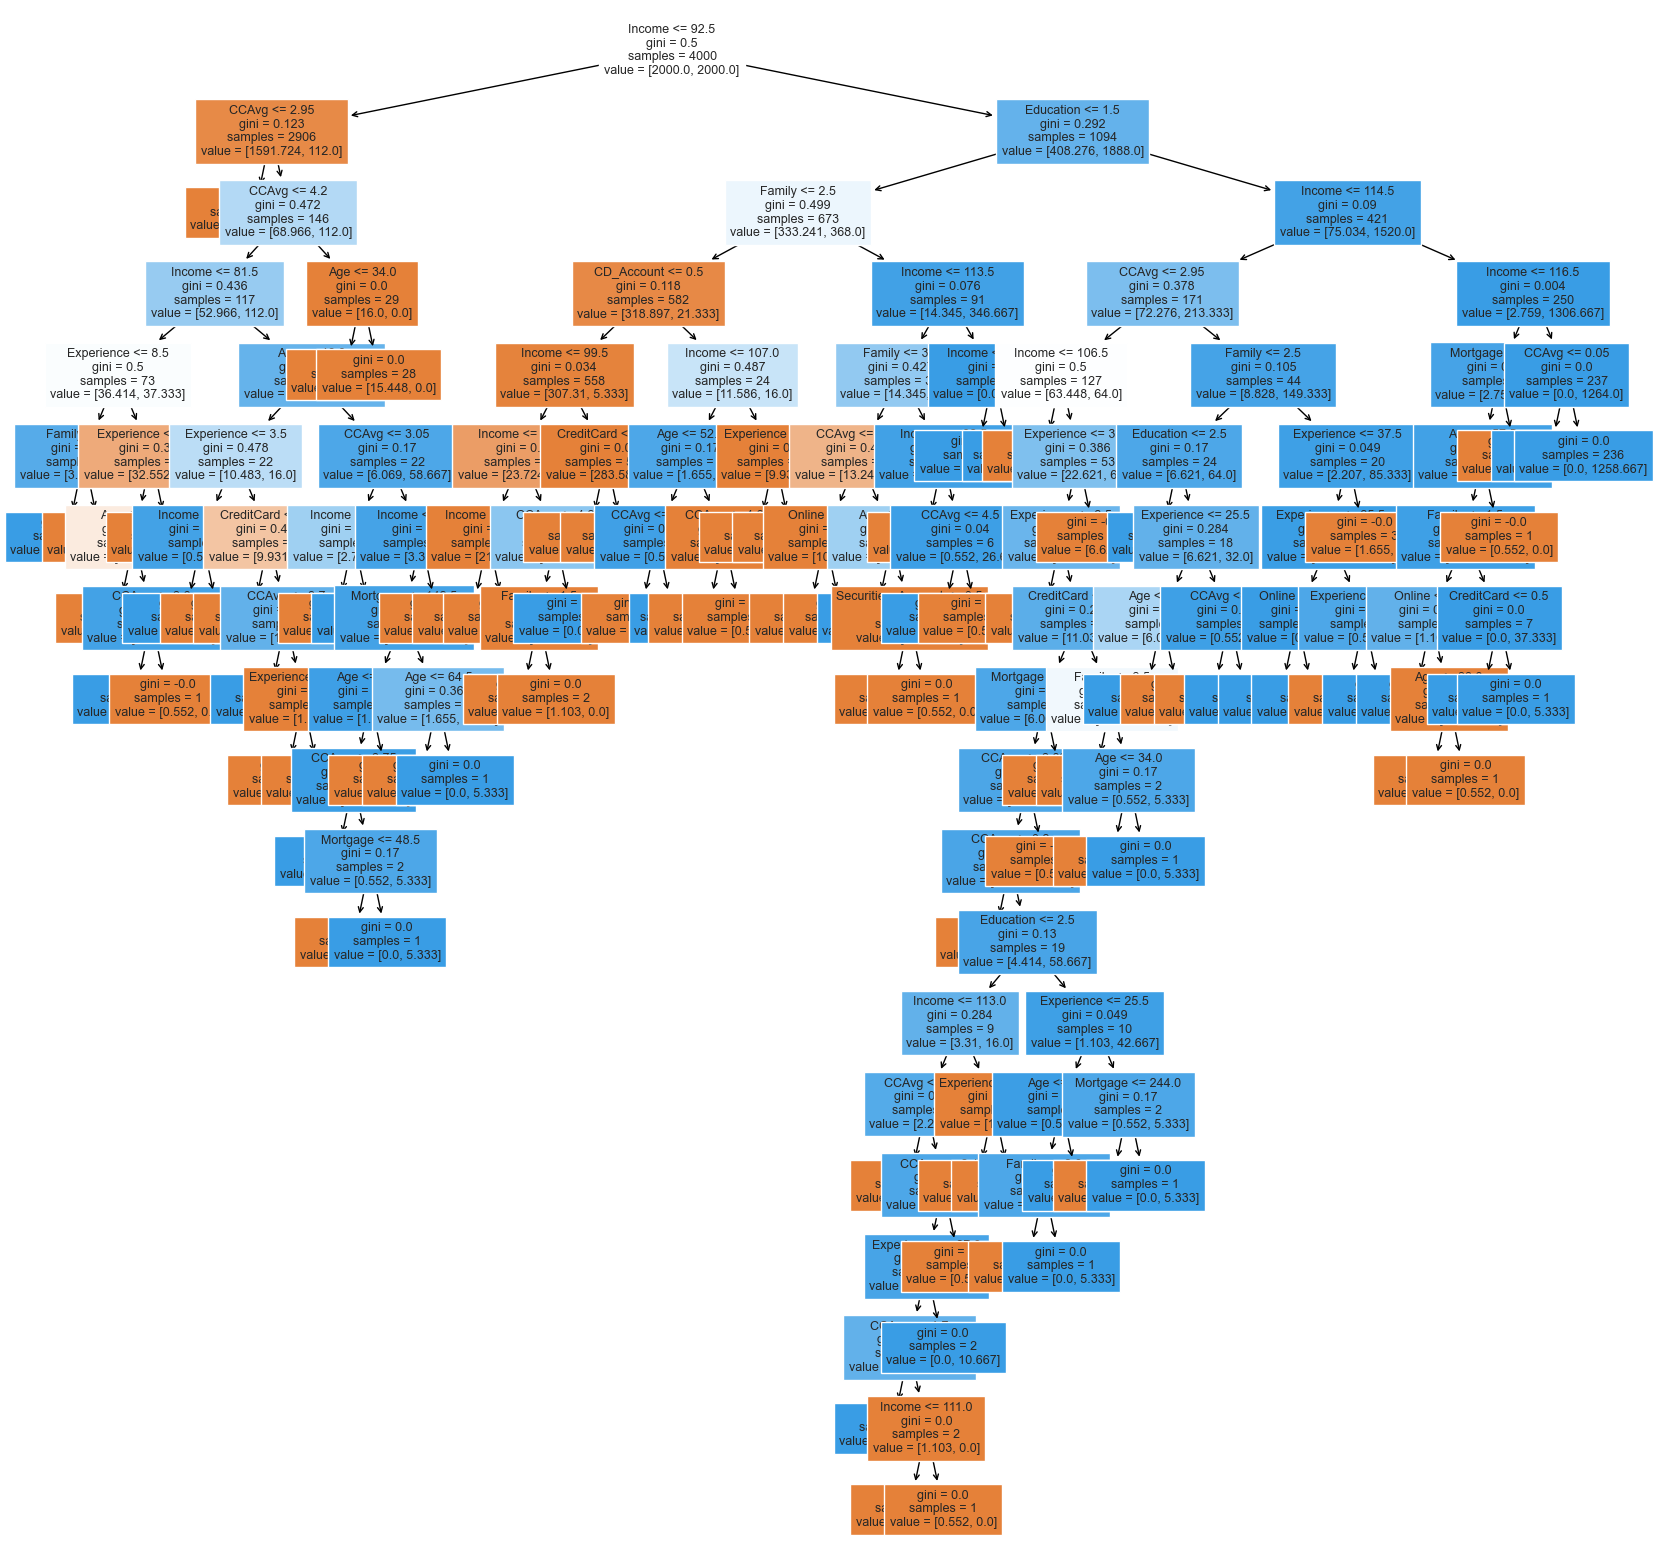

In [150]:
plot_decision_tree(dt_balanced, X_train)

In [151]:
print_tree_rules(dt_balanced, X_train.columns)

|--- Income <= 92.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [1522.76, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CCAvg <= 4.20
|   |   |   |--- Income <= 81.50
|   |   |   |   |--- Experience <= 8.50
|   |   |   |   |   |--- Family <= 3.50
|   |   |   |   |   |   |--- weights: [0.00, 26.67] class: 1
|   |   |   |   |   |--- Family >  3.50
|   |   |   |   |   |   |--- weights: [3.86, 0.00] class: 0
|   |   |   |   |--- Experience >  8.50
|   |   |   |   |   |--- Experience <= 18.50
|   |   |   |   |   |   |--- Age <= 42.50
|   |   |   |   |   |   |   |--- weights: [12.14, 0.00] class: 0
|   |   |   |   |   |   |--- Age >  42.50
|   |   |   |   |   |   |   |--- CCAvg <= 3.60
|   |   |   |   |   |   |   |   |--- weights: [0.00, 10.67] class: 1
|   |   |   |   |   |   |   |--- CCAvg >  3.60
|   |   |   |   |   |   |   |   |--- weights: [0.55, 0.00] class: 0
|   |   |   |   |   |--- Experience >  18.50
|   |   |   |   |   |   |--- weights: [19.86, 0.00] class: 0
|   |   |   |-

In [141]:
# top 4 featurs for default model
importances_default.head(4)


,feature,importance
5,Education,0.38
2,Income,0.30
3,Family,0.18
4,CCAvg,0.05


In [142]:
# top 4 featurs for balanced model
importances_balanced.head(4)

,feature,importance
2,Income,0.61
3,Family,0.15
4,CCAvg,0.09
5,Education,0.09


NOTE : 

- Weightage/Balanced model has more depth than default one (ie 18 > 13)
- Thereby Weightage/Balanced model has more nodes too (ie 175 > 125)
- The feature picked and priortized by both the models are different
  - Default focused on "Education & Income" primararily whereas Weightage/Balanced focused on "Income & Family" 

Seems Education should be regarded compared to Family Size for personal loan campaign, as first model converge earlier with less depth & almost equal **performance

#### Decision Tree (Pre-Prunning)

#### Decision Tree (Post-Prunning)